In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : [],
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_0_t1t2_normalized_e_e_e_1_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(2867343, 919)
(2867343, 8)
validation
(519557, 919)
(519557, 8)
test
(237229, 919)
(237229, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 919)]             0         


 dense (Dense)               (None, 1024)              942080    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1632136 (6.23 MB)


Trainable params: 1632136 (6.23 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/287 [..............................] - ETA: 6:27 - loss: 2.2344 - STD: 0.0865 - MAE: 0.2182

  4/287 [..............................] - ETA: 4s - loss: 2.1155 - STD: 0.0577 - MAE: 0.2166  

  6/287 [..............................] - ETA: 44s - loss: 2.1061 - STD: 0.0513 - MAE: 0.2167

  9/287 [..............................] - ETA: 29s - loss: 2.0968 - STD: 0.0466 - MAE: 0.2168

 12/287 [>.............................] - ETA: 22s - loss: 2.0857 - STD: 0.0439 - MAE: 0.2167

 16/287 [>.............................] - ETA: 17s - loss: 2.0778 - STD: 0.0417 - MAE: 0.2167

 20/287 [=>............................] - ETA: 14s - loss: 2.0734 - STD: 0.0403 - MAE: 0.2167

 24/287 [=>............................] - ETA: 12s - loss: 2.0680 - STD: 0.0392 - MAE: 0.2166

 27/287 [=>............................] - ETA: 11s - loss: 2.0640 - STD: 0.0381 - MAE: 0.2165

 30/287 [==>...........................] - ETA: 10s - loss: 2.0592 - STD: 0.0377 - MAE: 0.2164

 33/287 [==>...........................] - ETA: 9s - loss: 2.0529 - STD: 0.0380 - MAE: 0.2161 

 36/287 [==>...........................] - ETA: 9s - loss: 2.0461 - STD: 0.0385 - MAE: 0.2158

 39/287 [===>..........................] - ETA: 8s - loss: 2.0381 - STD: 0.0400 - MAE: 0.2154

 43/287 [===>..........................] - ETA: 8s - loss: 2.0270 - STD: 0.0426 - MAE: 0.2147

 46/287 [===>..........................] - ETA: 7s - loss: 2.0181 - STD: 0.0444 - MAE: 0.2142

 50/287 [====>.........................] - ETA: 7s - loss: 2.0051 - STD: 0.0467 - MAE: 0.2134

 53/287 [====>.........................] - ETA: 7s - loss: 1.9945 - STD: 0.0486 - MAE: 0.2128

 56/287 [====>.........................] - ETA: 6s - loss: 1.9829 - STD: 0.0503 - MAE: 0.2122

 59/287 [=====>........................] - ETA: 6s - loss: 1.9705 - STD: 0.0523 - MAE: 0.2115

 63/287 [=====>........................] - ETA: 6s - loss: 1.9516 - STD: 0.0549 - MAE: 0.2105

 66/287 [=====>........................] - ETA: 6s - loss: 1.9355 - STD: 0.0571 - MAE: 0.2097

 70/287 [======>.......................] - ETA: 5s - loss: 1.9134 - STD: 0.0601 - MAE: 0.2084

 73/287 [======>.......................] - ETA: 5s - loss: 1.8969 - STD: 0.0626 - MAE: 0.2074

 76/287 [======>.......................] - ETA: 5s - loss: 1.8807 - STD: 0.0651 - MAE: 0.2065

 79/287 [=======>......................] - ETA: 5s - loss: 1.8646 - STD: 0.0676 - MAE: 0.2054

 82/287 [=======>......................] - ETA: 5s - loss: 1.8494 - STD: 0.0700 - MAE: 0.2044

 86/287 [=======>......................] - ETA: 5s - loss: 1.8295 - STD: 0.0732 - MAE: 0.2031

 89/287 [========>.....................] - ETA: 4s - loss: 1.8152 - STD: 0.0755 - MAE: 0.2021

 92/287 [========>.....................] - ETA: 4s - loss: 1.8014 - STD: 0.0777 - MAE: 0.2011

 96/287 [=========>....................] - ETA: 4s - loss: 1.7838 - STD: 0.0807 - MAE: 0.1999

 99/287 [=========>....................] - ETA: 4s - loss: 1.7713 - STD: 0.0828 - MAE: 0.1990

102/287 [=========>....................] - ETA: 4s - loss: 1.7592 - STD: 0.0849 - MAE: 0.1981

106/287 [==========>...................] - ETA: 4s - loss: 1.7436 - STD: 0.0875 - MAE: 0.1969

110/287 [==========>...................] - ETA: 4s - loss: 1.7288 - STD: 0.0901 - MAE: 0.1958

114/287 [==========>...................] - ETA: 3s - loss: 1.7146 - STD: 0.0925 - MAE: 0.1947

118/287 [===========>..................] - ETA: 3s - loss: 1.7010 - STD: 0.0949 - MAE: 0.1937

121/287 [===========>..................] - ETA: 3s - loss: 1.6913 - STD: 0.0965 - MAE: 0.1929

125/287 [============>.................] - ETA: 3s - loss: 1.6787 - STD: 0.0986 - MAE: 0.1919

129/287 [============>.................] - ETA: 3s - loss: 1.6664 - STD: 0.1007 - MAE: 0.1910

133/287 [============>.................] - ETA: 3s - loss: 1.6544 - STD: 0.1027 - MAE: 0.1900

136/287 [=============>................] - ETA: 3s - loss: 1.6463 - STD: 0.1041 - MAE: 0.1894

139/287 [=============>................] - ETA: 3s - loss: 1.6381 - STD: 0.1055 - MAE: 0.1887

142/287 [=============>................] - ETA: 3s - loss: 1.6302 - STD: 0.1068 - MAE: 0.1881

146/287 [==============>...............] - ETA: 3s - loss: 1.6201 - STD: 0.1085 - MAE: 0.1873

150/287 [==============>...............] - ETA: 2s - loss: 1.6104 - STD: 0.1102 - MAE: 0.1865

154/287 [===============>..............] - ETA: 2s - loss: 1.6011 - STD: 0.1118 - MAE: 0.1858

158/287 [===============>..............] - ETA: 2s - loss: 1.5918 - STD: 0.1133 - MAE: 0.1850

161/287 [===============>..............] - ETA: 2s - loss: 1.5852 - STD: 0.1144 - MAE: 0.1845

164/287 [================>.............] - ETA: 2s - loss: 1.5786 - STD: 0.1155 - MAE: 0.1840

167/287 [================>.............] - ETA: 2s - loss: 1.5721 - STD: 0.1166 - MAE: 0.1834

170/287 [================>.............] - ETA: 2s - loss: 1.5659 - STD: 0.1177 - MAE: 0.1829

173/287 [=================>............] - ETA: 2s - loss: 1.5597 - STD: 0.1187 - MAE: 0.1824

176/287 [=================>............] - ETA: 2s - loss: 1.5540 - STD: 0.1196 - MAE: 0.1820

179/287 [=================>............] - ETA: 2s - loss: 1.5486 - STD: 0.1206 - MAE: 0.1815

182/287 [==================>...........] - ETA: 2s - loss: 1.5428 - STD: 0.1215 - MAE: 0.1810

185/287 [==================>...........] - ETA: 2s - loss: 1.5375 - STD: 0.1225 - MAE: 0.1806

188/287 [==================>...........] - ETA: 2s - loss: 1.5322 - STD: 0.1234 - MAE: 0.1801

191/287 [==================>...........] - ETA: 1s - loss: 1.5271 - STD: 0.1242 - MAE: 0.1797

195/287 [===================>..........] - ETA: 1s - loss: 1.5200 - STD: 0.1254 - MAE: 0.1791

198/287 [===================>..........] - ETA: 1s - loss: 1.5150 - STD: 0.1262 - MAE: 0.1787

202/287 [====================>.........] - ETA: 1s - loss: 1.5085 - STD: 0.1273 - MAE: 0.1782

205/287 [====================>.........] - ETA: 1s - loss: 1.5038 - STD: 0.1281 - MAE: 0.1778

208/287 [====================>.........] - ETA: 1s - loss: 1.4990 - STD: 0.1288 - MAE: 0.1774

211/287 [=====================>........] - ETA: 1s - loss: 1.4942 - STD: 0.1296 - MAE: 0.1770

214/287 [=====================>........] - ETA: 1s - loss: 1.4899 - STD: 0.1303 - MAE: 0.1766

217/287 [=====================>........] - ETA: 1s - loss: 1.4859 - STD: 0.1311 - MAE: 0.1763

220/287 [=====================>........] - ETA: 1s - loss: 1.4815 - STD: 0.1318 - MAE: 0.1759

224/287 [======================>.......] - ETA: 1s - loss: 1.4756 - STD: 0.1327 - MAE: 0.1754

227/287 [======================>.......] - ETA: 1s - loss: 1.4714 - STD: 0.1334 - MAE: 0.1750

231/287 [=======================>......] - ETA: 1s - loss: 1.4658 - STD: 0.1343 - MAE: 0.1746

234/287 [=======================>......] - ETA: 1s - loss: 1.4620 - STD: 0.1349 - MAE: 0.1742

237/287 [=======================>......] - ETA: 1s - loss: 1.4582 - STD: 0.1356 - MAE: 0.1739

240/287 [========================>.....] - ETA: 0s - loss: 1.4543 - STD: 0.1362 - MAE: 0.1736

243/287 [========================>.....] - ETA: 0s - loss: 1.4506 - STD: 0.1368 - MAE: 0.1733

247/287 [========================>.....] - ETA: 0s - loss: 1.4456 - STD: 0.1376 - MAE: 0.1728

251/287 [=========================>....] - ETA: 0s - loss: 1.4406 - STD: 0.1384 - MAE: 0.1724

254/287 [=========================>....] - ETA: 0s - loss: 1.4369 - STD: 0.1390 - MAE: 0.1721

257/287 [=========================>....] - ETA: 0s - loss: 1.4334 - STD: 0.1396 - MAE: 0.1718

260/287 [==========================>...] - ETA: 0s - loss: 1.4300 - STD: 0.1401 - MAE: 0.1715

263/287 [==========================>...] - ETA: 0s - loss: 1.4265 - STD: 0.1407 - MAE: 0.1712

266/287 [==========================>...] - ETA: 0s - loss: 1.4232 - STD: 0.1412 - MAE: 0.1709

270/287 [===========================>..] - ETA: 0s - loss: 1.4188 - STD: 0.1419 - MAE: 0.1705

273/287 [===========================>..] - ETA: 0s - loss: 1.4155 - STD: 0.1425 - MAE: 0.1702

276/287 [===========================>..] - ETA: 0s - loss: 1.4126 - STD: 0.1430 - MAE: 0.1699

280/287 [============================>.] - ETA: 0s - loss: 1.4086 - STD: 0.1437 - MAE: 0.1696

283/287 [============================>.] - ETA: 0s - loss: 1.4057 - STD: 0.1442 - MAE: 0.1693

286/287 [============================>.] - ETA: 0s - loss: 1.4025 - STD: 0.1447 - MAE: 0.1690

287/287 [==============================] - 8s 25ms/step - loss: 1.4015 - STD: 0.1449 - MAE: 0.1689 - val_loss: 1.3235 - val_STD: 0.1887 - val_MAE: 0.1547


Epoch 2/10000


  1/287 [..............................] - ETA: 13s - loss: 1.1125 - STD: 0.1901 - MAE: 0.1437

  4/287 [..............................] - ETA: 5s - loss: 1.1092 - STD: 0.1907 - MAE: 0.1435 

  7/287 [..............................] - ETA: 5s - loss: 1.1116 - STD: 0.1906 - MAE: 0.1437

 10/287 [>.............................] - ETA: 5s - loss: 1.1112 - STD: 0.1910 - MAE: 0.1435

 13/287 [>.............................] - ETA: 5s - loss: 1.1109 - STD: 0.1914 - MAE: 0.1434

 16/287 [>.............................] - ETA: 5s - loss: 1.1092 - STD: 0.1914 - MAE: 0.1433

 19/287 [>.............................] - ETA: 4s - loss: 1.1087 - STD: 0.1917 - MAE: 0.1432

 22/287 [=>............................] - ETA: 4s - loss: 1.1066 - STD: 0.1918 - MAE: 0.1430

 25/287 [=>............................] - ETA: 4s - loss: 1.1060 - STD: 0.1921 - MAE: 0.1428

 28/287 [=>............................] - ETA: 4s - loss: 1.1062 - STD: 0.1923 - MAE: 0.1428

 31/287 [==>...........................] - ETA: 4s - loss: 1.1056 - STD: 0.1924 - MAE: 0.1427

 34/287 [==>...........................] - ETA: 4s - loss: 1.1044 - STD: 0.1927 - MAE: 0.1426

 37/287 [==>...........................] - ETA: 4s - loss: 1.1060 - STD: 0.1928 - MAE: 0.1426

 40/287 [===>..........................] - ETA: 4s - loss: 1.1060 - STD: 0.1929 - MAE: 0.1426

 43/287 [===>..........................] - ETA: 4s - loss: 1.1048 - STD: 0.1930 - MAE: 0.1424

 46/287 [===>..........................] - ETA: 4s - loss: 1.1045 - STD: 0.1931 - MAE: 0.1424

 49/287 [====>.........................] - ETA: 4s - loss: 1.1037 - STD: 0.1932 - MAE: 0.1423

 52/287 [====>.........................] - ETA: 4s - loss: 1.1032 - STD: 0.1933 - MAE: 0.1423

 55/287 [====>.........................] - ETA: 4s - loss: 1.1032 - STD: 0.1933 - MAE: 0.1423

 58/287 [=====>........................] - ETA: 4s - loss: 1.1024 - STD: 0.1933 - MAE: 0.1422

 61/287 [=====>........................] - ETA: 4s - loss: 1.1011 - STD: 0.1934 - MAE: 0.1421

 64/287 [=====>........................] - ETA: 4s - loss: 1.1008 - STD: 0.1935 - MAE: 0.1421

 67/287 [======>.......................] - ETA: 4s - loss: 1.1000 - STD: 0.1936 - MAE: 0.1420

 70/287 [======>.......................] - ETA: 4s - loss: 1.0991 - STD: 0.1937 - MAE: 0.1419

 73/287 [======>.......................] - ETA: 3s - loss: 1.0989 - STD: 0.1939 - MAE: 0.1418

 76/287 [======>.......................] - ETA: 3s - loss: 1.0975 - STD: 0.1940 - MAE: 0.1417

 79/287 [=======>......................] - ETA: 3s - loss: 1.0968 - STD: 0.1941 - MAE: 0.1416

 82/287 [=======>......................] - ETA: 3s - loss: 1.0958 - STD: 0.1942 - MAE: 0.1415

 85/287 [=======>......................] - ETA: 3s - loss: 1.0950 - STD: 0.1943 - MAE: 0.1414

 88/287 [========>.....................] - ETA: 3s - loss: 1.0943 - STD: 0.1944 - MAE: 0.1413

 91/287 [========>.....................] - ETA: 3s - loss: 1.0933 - STD: 0.1945 - MAE: 0.1413

 94/287 [========>.....................] - ETA: 3s - loss: 1.0922 - STD: 0.1946 - MAE: 0.1412

 97/287 [=========>....................] - ETA: 3s - loss: 1.0912 - STD: 0.1947 - MAE: 0.1411

100/287 [=========>....................] - ETA: 3s - loss: 1.0902 - STD: 0.1948 - MAE: 0.1410

103/287 [=========>....................] - ETA: 3s - loss: 1.0892 - STD: 0.1949 - MAE: 0.1409

106/287 [==========>...................] - ETA: 3s - loss: 1.0883 - STD: 0.1950 - MAE: 0.1408

109/287 [==========>...................] - ETA: 3s - loss: 1.0876 - STD: 0.1951 - MAE: 0.1407

112/287 [==========>...................] - ETA: 3s - loss: 1.0870 - STD: 0.1952 - MAE: 0.1406

115/287 [===========>..................] - ETA: 3s - loss: 1.0861 - STD: 0.1953 - MAE: 0.1405

118/287 [===========>..................] - ETA: 3s - loss: 1.0853 - STD: 0.1954 - MAE: 0.1405

121/287 [===========>..................] - ETA: 3s - loss: 1.0845 - STD: 0.1955 - MAE: 0.1404

124/287 [===========>..................] - ETA: 3s - loss: 1.0835 - STD: 0.1956 - MAE: 0.1403

127/287 [============>.................] - ETA: 2s - loss: 1.0825 - STD: 0.1957 - MAE: 0.1402

130/287 [============>.................] - ETA: 2s - loss: 1.0820 - STD: 0.1959 - MAE: 0.1401

133/287 [============>.................] - ETA: 2s - loss: 1.0816 - STD: 0.1960 - MAE: 0.1400

136/287 [=============>................] - ETA: 2s - loss: 1.0809 - STD: 0.1961 - MAE: 0.1400

139/287 [=============>................] - ETA: 2s - loss: 1.0800 - STD: 0.1962 - MAE: 0.1399

142/287 [=============>................] - ETA: 2s - loss: 1.0792 - STD: 0.1963 - MAE: 0.1398

145/287 [==============>...............] - ETA: 2s - loss: 1.0783 - STD: 0.1964 - MAE: 0.1397

148/287 [==============>...............] - ETA: 2s - loss: 1.0774 - STD: 0.1965 - MAE: 0.1396

151/287 [==============>...............] - ETA: 2s - loss: 1.0765 - STD: 0.1966 - MAE: 0.1395

154/287 [===============>..............] - ETA: 2s - loss: 1.0757 - STD: 0.1967 - MAE: 0.1394

157/287 [===============>..............] - ETA: 2s - loss: 1.0749 - STD: 0.1968 - MAE: 0.1393

160/287 [===============>..............] - ETA: 2s - loss: 1.0743 - STD: 0.1969 - MAE: 0.1393

164/287 [================>.............] - ETA: 2s - loss: 1.0744 - STD: 0.1971 - MAE: 0.1392

167/287 [================>.............] - ETA: 2s - loss: 1.0736 - STD: 0.1972 - MAE: 0.1391

170/287 [================>.............] - ETA: 2s - loss: 1.0727 - STD: 0.1973 - MAE: 0.1391

173/287 [=================>............] - ETA: 2s - loss: 1.0722 - STD: 0.1974 - MAE: 0.1390

177/287 [=================>............] - ETA: 2s - loss: 1.0711 - STD: 0.1975 - MAE: 0.1389

181/287 [=================>............] - ETA: 1s - loss: 1.0700 - STD: 0.1976 - MAE: 0.1388

185/287 [==================>...........] - ETA: 1s - loss: 1.0690 - STD: 0.1978 - MAE: 0.1386

189/287 [==================>...........] - ETA: 1s - loss: 1.0682 - STD: 0.1979 - MAE: 0.1385

192/287 [===================>..........] - ETA: 1s - loss: 1.0678 - STD: 0.1980 - MAE: 0.1385

195/287 [===================>..........] - ETA: 1s - loss: 1.0673 - STD: 0.1981 - MAE: 0.1384

198/287 [===================>..........] - ETA: 1s - loss: 1.0667 - STD: 0.1982 - MAE: 0.1384

201/287 [====================>.........] - ETA: 1s - loss: 1.0663 - STD: 0.1983 - MAE: 0.1383

204/287 [====================>.........] - ETA: 1s - loss: 1.0660 - STD: 0.1984 - MAE: 0.1382

207/287 [====================>.........] - ETA: 1s - loss: 1.0653 - STD: 0.1985 - MAE: 0.1382

210/287 [====================>.........] - ETA: 1s - loss: 1.0646 - STD: 0.1986 - MAE: 0.1381

213/287 [=====================>........] - ETA: 1s - loss: 1.0641 - STD: 0.1986 - MAE: 0.1380

216/287 [=====================>........] - ETA: 1s - loss: 1.0635 - STD: 0.1987 - MAE: 0.1380

219/287 [=====================>........] - ETA: 1s - loss: 1.0629 - STD: 0.1988 - MAE: 0.1379

223/287 [======================>.......] - ETA: 1s - loss: 1.0620 - STD: 0.1989 - MAE: 0.1378

226/287 [======================>.......] - ETA: 1s - loss: 1.0614 - STD: 0.1990 - MAE: 0.1377

229/287 [======================>.......] - ETA: 1s - loss: 1.0608 - STD: 0.1991 - MAE: 0.1377

232/287 [=======================>......] - ETA: 1s - loss: 1.0600 - STD: 0.1992 - MAE: 0.1376

235/287 [=======================>......] - ETA: 0s - loss: 1.0593 - STD: 0.1993 - MAE: 0.1375

239/287 [=======================>......] - ETA: 0s - loss: 1.0584 - STD: 0.1994 - MAE: 0.1374

243/287 [========================>.....] - ETA: 0s - loss: 1.0575 - STD: 0.1995 - MAE: 0.1373

247/287 [========================>.....] - ETA: 0s - loss: 1.0566 - STD: 0.1996 - MAE: 0.1372

251/287 [=========================>....] - ETA: 0s - loss: 1.0557 - STD: 0.1997 - MAE: 0.1371

254/287 [=========================>....] - ETA: 0s - loss: 1.0550 - STD: 0.1998 - MAE: 0.1371

257/287 [=========================>....] - ETA: 0s - loss: 1.0543 - STD: 0.1999 - MAE: 0.1370

260/287 [==========================>...] - ETA: 0s - loss: 1.0536 - STD: 0.1999 - MAE: 0.1369

263/287 [==========================>...] - ETA: 0s - loss: 1.0529 - STD: 0.2000 - MAE: 0.1369

267/287 [==========================>...] - ETA: 0s - loss: 1.0519 - STD: 0.2002 - MAE: 0.1367

271/287 [===========================>..] - ETA: 0s - loss: 1.0510 - STD: 0.2003 - MAE: 0.1366

274/287 [===========================>..] - ETA: 0s - loss: 1.0504 - STD: 0.2004 - MAE: 0.1366

277/287 [===========================>..] - ETA: 0s - loss: 1.0501 - STD: 0.2005 - MAE: 0.1365

280/287 [============================>.] - ETA: 0s - loss: 1.0496 - STD: 0.2006 - MAE: 0.1365

283/287 [============================>.] - ETA: 0s - loss: 1.0490 - STD: 0.2007 - MAE: 0.1364

287/287 [==============================] - ETA: 0s - loss: 1.0481 - STD: 0.2008 - MAE: 0.1363

287/287 [==============================] - 6s 21ms/step - loss: 1.0481 - STD: 0.2008 - MAE: 0.1363 - val_loss: 1.3073 - val_STD: 0.2091 - val_MAE: 0.1466


Epoch 3/10000


  1/287 [..............................] - ETA: 13s - loss: 1.0017 - STD: 0.2092 - MAE: 0.1305

  4/287 [..............................] - ETA: 5s - loss: 0.9877 - STD: 0.2096 - MAE: 0.1296 

  7/287 [..............................] - ETA: 5s - loss: 0.9894 - STD: 0.2090 - MAE: 0.1299

 10/287 [>.............................] - ETA: 5s - loss: 0.9852 - STD: 0.2091 - MAE: 0.1295

 13/287 [>.............................] - ETA: 5s - loss: 0.9846 - STD: 0.2091 - MAE: 0.1295

 16/287 [>.............................] - ETA: 5s - loss: 0.9969 - STD: 0.2093 - MAE: 0.1301

 19/287 [>.............................] - ETA: 4s - loss: 0.9973 - STD: 0.2095 - MAE: 0.1300

 22/287 [=>............................] - ETA: 4s - loss: 1.0006 - STD: 0.2095 - MAE: 0.1302

 25/287 [=>............................] - ETA: 4s - loss: 1.0005 - STD: 0.2095 - MAE: 0.1302

 28/287 [=>............................] - ETA: 4s - loss: 0.9986 - STD: 0.2096 - MAE: 0.1301

 31/287 [==>...........................] - ETA: 4s - loss: 0.9979 - STD: 0.2096 - MAE: 0.1301

 34/287 [==>...........................] - ETA: 4s - loss: 0.9980 - STD: 0.2095 - MAE: 0.1301

 37/287 [==>...........................] - ETA: 4s - loss: 0.9959 - STD: 0.2095 - MAE: 0.1300

 40/287 [===>..........................] - ETA: 4s - loss: 0.9947 - STD: 0.2094 - MAE: 0.1299

 43/287 [===>..........................] - ETA: 4s - loss: 0.9931 - STD: 0.2094 - MAE: 0.1298

 46/287 [===>..........................] - ETA: 4s - loss: 0.9915 - STD: 0.2094 - MAE: 0.1297

 49/287 [====>.........................] - ETA: 4s - loss: 0.9903 - STD: 0.2094 - MAE: 0.1297

 52/287 [====>.........................] - ETA: 4s - loss: 0.9891 - STD: 0.2095 - MAE: 0.1296

 55/287 [====>.........................] - ETA: 4s - loss: 0.9883 - STD: 0.2096 - MAE: 0.1295

 58/287 [=====>........................] - ETA: 4s - loss: 0.9890 - STD: 0.2096 - MAE: 0.1295

 61/287 [=====>........................] - ETA: 4s - loss: 0.9890 - STD: 0.2097 - MAE: 0.1295

 64/287 [=====>........................] - ETA: 4s - loss: 0.9887 - STD: 0.2097 - MAE: 0.1294

 67/287 [======>.......................] - ETA: 4s - loss: 0.9883 - STD: 0.2098 - MAE: 0.1294

 70/287 [======>.......................] - ETA: 4s - loss: 0.9873 - STD: 0.2098 - MAE: 0.1294

 73/287 [======>.......................] - ETA: 3s - loss: 0.9865 - STD: 0.2099 - MAE: 0.1293

 76/287 [======>.......................] - ETA: 3s - loss: 0.9856 - STD: 0.2099 - MAE: 0.1292

 79/287 [=======>......................] - ETA: 3s - loss: 0.9847 - STD: 0.2100 - MAE: 0.1291

 82/287 [=======>......................] - ETA: 3s - loss: 0.9838 - STD: 0.2100 - MAE: 0.1290

 85/287 [=======>......................] - ETA: 3s - loss: 0.9828 - STD: 0.2101 - MAE: 0.1289

 88/287 [========>.....................] - ETA: 3s - loss: 0.9818 - STD: 0.2102 - MAE: 0.1289

 91/287 [========>.....................] - ETA: 3s - loss: 0.9815 - STD: 0.2102 - MAE: 0.1288

 94/287 [========>.....................] - ETA: 3s - loss: 0.9808 - STD: 0.2102 - MAE: 0.1288

 97/287 [=========>....................] - ETA: 3s - loss: 0.9803 - STD: 0.2103 - MAE: 0.1287

100/287 [=========>....................] - ETA: 3s - loss: 0.9797 - STD: 0.2104 - MAE: 0.1286

103/287 [=========>....................] - ETA: 3s - loss: 0.9791 - STD: 0.2105 - MAE: 0.1286

107/287 [==========>...................] - ETA: 3s - loss: 0.9784 - STD: 0.2105 - MAE: 0.1285

110/287 [==========>...................] - ETA: 3s - loss: 0.9774 - STD: 0.2106 - MAE: 0.1284

114/287 [==========>...................] - ETA: 3s - loss: 0.9764 - STD: 0.2107 - MAE: 0.1283

117/287 [===========>..................] - ETA: 3s - loss: 0.9756 - STD: 0.2108 - MAE: 0.1282

120/287 [===========>..................] - ETA: 3s - loss: 0.9750 - STD: 0.2108 - MAE: 0.1282

123/287 [===========>..................] - ETA: 2s - loss: 0.9746 - STD: 0.2109 - MAE: 0.1281

126/287 [============>.................] - ETA: 2s - loss: 0.9746 - STD: 0.2110 - MAE: 0.1281

129/287 [============>.................] - ETA: 2s - loss: 0.9742 - STD: 0.2110 - MAE: 0.1280

132/287 [============>.................] - ETA: 2s - loss: 0.9738 - STD: 0.2111 - MAE: 0.1280

135/287 [=============>................] - ETA: 2s - loss: 0.9737 - STD: 0.2112 - MAE: 0.1280

138/287 [=============>................] - ETA: 2s - loss: 0.9733 - STD: 0.2113 - MAE: 0.1279

141/287 [=============>................] - ETA: 2s - loss: 0.9726 - STD: 0.2113 - MAE: 0.1278

144/287 [==============>...............] - ETA: 2s - loss: 0.9721 - STD: 0.2114 - MAE: 0.1278

147/287 [==============>...............] - ETA: 2s - loss: 0.9717 - STD: 0.2114 - MAE: 0.1278

150/287 [==============>...............] - ETA: 2s - loss: 0.9712 - STD: 0.2115 - MAE: 0.1277

153/287 [==============>...............] - ETA: 2s - loss: 0.9704 - STD: 0.2115 - MAE: 0.1276

156/287 [===============>..............] - ETA: 2s - loss: 0.9698 - STD: 0.2116 - MAE: 0.1276

159/287 [===============>..............] - ETA: 2s - loss: 0.9698 - STD: 0.2116 - MAE: 0.1275

162/287 [===============>..............] - ETA: 2s - loss: 0.9694 - STD: 0.2117 - MAE: 0.1275

165/287 [================>.............] - ETA: 2s - loss: 0.9693 - STD: 0.2118 - MAE: 0.1275

168/287 [================>.............] - ETA: 2s - loss: 0.9693 - STD: 0.2118 - MAE: 0.1275

171/287 [================>.............] - ETA: 2s - loss: 0.9688 - STD: 0.2119 - MAE: 0.1274

174/287 [=================>............] - ETA: 2s - loss: 0.9684 - STD: 0.2119 - MAE: 0.1274

177/287 [=================>............] - ETA: 1s - loss: 0.9678 - STD: 0.2119 - MAE: 0.1273

180/287 [=================>............] - ETA: 1s - loss: 0.9674 - STD: 0.2120 - MAE: 0.1273

183/287 [==================>...........] - ETA: 1s - loss: 0.9676 - STD: 0.2120 - MAE: 0.1273

186/287 [==================>...........] - ETA: 1s - loss: 0.9674 - STD: 0.2121 - MAE: 0.1272

189/287 [==================>...........] - ETA: 1s - loss: 0.9671 - STD: 0.2122 - MAE: 0.1272

192/287 [===================>..........] - ETA: 1s - loss: 0.9666 - STD: 0.2122 - MAE: 0.1271

195/287 [===================>..........] - ETA: 1s - loss: 0.9662 - STD: 0.2123 - MAE: 0.1271

198/287 [===================>..........] - ETA: 1s - loss: 0.9661 - STD: 0.2123 - MAE: 0.1271

201/287 [====================>.........] - ETA: 1s - loss: 0.9658 - STD: 0.2123 - MAE: 0.1270

205/287 [====================>.........] - ETA: 1s - loss: 0.9654 - STD: 0.2124 - MAE: 0.1270

208/287 [====================>.........] - ETA: 1s - loss: 0.9652 - STD: 0.2124 - MAE: 0.1269

212/287 [=====================>........] - ETA: 1s - loss: 0.9649 - STD: 0.2125 - MAE: 0.1269

216/287 [=====================>........] - ETA: 1s - loss: 0.9641 - STD: 0.2126 - MAE: 0.1268

219/287 [=====================>........] - ETA: 1s - loss: 0.9636 - STD: 0.2126 - MAE: 0.1268

222/287 [======================>.......] - ETA: 1s - loss: 0.9631 - STD: 0.2127 - MAE: 0.1267

226/287 [======================>.......] - ETA: 1s - loss: 0.9625 - STD: 0.2127 - MAE: 0.1267

230/287 [=======================>......] - ETA: 1s - loss: 0.9617 - STD: 0.2128 - MAE: 0.1266

233/287 [=======================>......] - ETA: 0s - loss: 0.9611 - STD: 0.2129 - MAE: 0.1265

236/287 [=======================>......] - ETA: 0s - loss: 0.9606 - STD: 0.2129 - MAE: 0.1265

239/287 [=======================>......] - ETA: 0s - loss: 0.9600 - STD: 0.2130 - MAE: 0.1264

242/287 [========================>.....] - ETA: 0s - loss: 0.9594 - STD: 0.2130 - MAE: 0.1264

245/287 [========================>.....] - ETA: 0s - loss: 0.9589 - STD: 0.2131 - MAE: 0.1263

248/287 [========================>.....] - ETA: 0s - loss: 0.9584 - STD: 0.2131 - MAE: 0.1263

252/287 [=========================>....] - ETA: 0s - loss: 0.9578 - STD: 0.2132 - MAE: 0.1262

256/287 [=========================>....] - ETA: 0s - loss: 0.9575 - STD: 0.2133 - MAE: 0.1261

260/287 [==========================>...] - ETA: 0s - loss: 0.9570 - STD: 0.2133 - MAE: 0.1261

263/287 [==========================>...] - ETA: 0s - loss: 0.9567 - STD: 0.2134 - MAE: 0.1260

266/287 [==========================>...] - ETA: 0s - loss: 0.9564 - STD: 0.2135 - MAE: 0.1260

270/287 [===========================>..] - ETA: 0s - loss: 0.9562 - STD: 0.2135 - MAE: 0.1260

274/287 [===========================>..] - ETA: 0s - loss: 0.9559 - STD: 0.2136 - MAE: 0.1259

277/287 [===========================>..] - ETA: 0s - loss: 0.9556 - STD: 0.2136 - MAE: 0.1259

280/287 [============================>.] - ETA: 0s - loss: 0.9554 - STD: 0.2137 - MAE: 0.1258

283/287 [============================>.] - ETA: 0s - loss: 0.9554 - STD: 0.2137 - MAE: 0.1258

286/287 [============================>.] - ETA: 0s - loss: 0.9551 - STD: 0.2138 - MAE: 0.1258

287/287 [==============================] - 6s 21ms/step - loss: 0.9549 - STD: 0.2138 - MAE: 0.1258 - val_loss: 1.2589 - val_STD: 0.2182 - val_MAE: 0.1405


Epoch 4/10000


  1/287 [..............................] - ETA: 11s - loss: 0.9153 - STD: 0.2193 - MAE: 0.1214

  4/287 [..............................] - ETA: 5s - loss: 0.9096 - STD: 0.2184 - MAE: 0.1213 

  7/287 [..............................] - ETA: 4s - loss: 0.9070 - STD: 0.2182 - MAE: 0.1211

 10/287 [>.............................] - ETA: 4s - loss: 0.9065 - STD: 0.2182 - MAE: 0.1211

 13/287 [>.............................] - ETA: 4s - loss: 0.9053 - STD: 0.2181 - MAE: 0.1210

 16/287 [>.............................] - ETA: 4s - loss: 0.9096 - STD: 0.2181 - MAE: 0.1213

 19/287 [>.............................] - ETA: 4s - loss: 0.9095 - STD: 0.2181 - MAE: 0.1213

 23/287 [=>............................] - ETA: 4s - loss: 0.9084 - STD: 0.2182 - MAE: 0.1211

 27/287 [=>............................] - ETA: 4s - loss: 0.9081 - STD: 0.2184 - MAE: 0.1210

 31/287 [==>...........................] - ETA: 4s - loss: 0.9096 - STD: 0.2185 - MAE: 0.1211

 34/287 [==>...........................] - ETA: 4s - loss: 0.9105 - STD: 0.2187 - MAE: 0.1210

 37/287 [==>...........................] - ETA: 4s - loss: 0.9107 - STD: 0.2187 - MAE: 0.1210

 40/287 [===>..........................] - ETA: 4s - loss: 0.9102 - STD: 0.2188 - MAE: 0.1210

 43/287 [===>..........................] - ETA: 4s - loss: 0.9091 - STD: 0.2189 - MAE: 0.1208

 46/287 [===>..........................] - ETA: 4s - loss: 0.9088 - STD: 0.2190 - MAE: 0.1208

 50/287 [====>.........................] - ETA: 4s - loss: 0.9083 - STD: 0.2190 - MAE: 0.1207

 54/287 [====>.........................] - ETA: 3s - loss: 0.9068 - STD: 0.2191 - MAE: 0.1206

 58/287 [=====>........................] - ETA: 3s - loss: 0.9058 - STD: 0.2192 - MAE: 0.1205

 61/287 [=====>........................] - ETA: 3s - loss: 0.9052 - STD: 0.2193 - MAE: 0.1204

 64/287 [=====>........................] - ETA: 3s - loss: 0.9054 - STD: 0.2194 - MAE: 0.1204

 67/287 [======>.......................] - ETA: 3s - loss: 0.9049 - STD: 0.2194 - MAE: 0.1204

 71/287 [======>.......................] - ETA: 3s - loss: 0.9044 - STD: 0.2195 - MAE: 0.1203

 75/287 [======>.......................] - ETA: 3s - loss: 0.9043 - STD: 0.2196 - MAE: 0.1203

 79/287 [=======>......................] - ETA: 3s - loss: 0.9041 - STD: 0.2197 - MAE: 0.1202

 82/287 [=======>......................] - ETA: 3s - loss: 0.9040 - STD: 0.2198 - MAE: 0.1201

 85/287 [=======>......................] - ETA: 3s - loss: 0.9042 - STD: 0.2199 - MAE: 0.1201

 88/287 [========>.....................] - ETA: 3s - loss: 0.9055 - STD: 0.2200 - MAE: 0.1201

 91/287 [========>.....................] - ETA: 3s - loss: 0.9055 - STD: 0.2200 - MAE: 0.1201

 94/287 [========>.....................] - ETA: 3s - loss: 0.9052 - STD: 0.2200 - MAE: 0.1201

 97/287 [=========>....................] - ETA: 3s - loss: 0.9051 - STD: 0.2201 - MAE: 0.1201

100/287 [=========>....................] - ETA: 3s - loss: 0.9054 - STD: 0.2201 - MAE: 0.1201

103/287 [=========>....................] - ETA: 3s - loss: 0.9052 - STD: 0.2202 - MAE: 0.1200

107/287 [==========>...................] - ETA: 3s - loss: 0.9056 - STD: 0.2202 - MAE: 0.1200

110/287 [==========>...................] - ETA: 3s - loss: 0.9060 - STD: 0.2203 - MAE: 0.1200

113/287 [==========>...................] - ETA: 2s - loss: 0.9070 - STD: 0.2203 - MAE: 0.1201

116/287 [===========>..................] - ETA: 2s - loss: 0.9072 - STD: 0.2204 - MAE: 0.1201

119/287 [===========>..................] - ETA: 2s - loss: 0.9074 - STD: 0.2204 - MAE: 0.1201

123/287 [===========>..................] - ETA: 2s - loss: 0.9072 - STD: 0.2205 - MAE: 0.1200

126/287 [============>.................] - ETA: 2s - loss: 0.9068 - STD: 0.2205 - MAE: 0.1200

130/287 [============>.................] - ETA: 2s - loss: 0.9063 - STD: 0.2205 - MAE: 0.1200

133/287 [============>.................] - ETA: 2s - loss: 0.9057 - STD: 0.2205 - MAE: 0.1199

137/287 [=============>................] - ETA: 2s - loss: 0.9052 - STD: 0.2205 - MAE: 0.1199

141/287 [=============>................] - ETA: 2s - loss: 0.9046 - STD: 0.2206 - MAE: 0.1198

144/287 [==============>...............] - ETA: 2s - loss: 0.9041 - STD: 0.2207 - MAE: 0.1198

148/287 [==============>...............] - ETA: 2s - loss: 0.9037 - STD: 0.2207 - MAE: 0.1197

152/287 [==============>...............] - ETA: 2s - loss: 0.9033 - STD: 0.2207 - MAE: 0.1197

155/287 [===============>..............] - ETA: 2s - loss: 0.9031 - STD: 0.2208 - MAE: 0.1197

158/287 [===============>..............] - ETA: 2s - loss: 0.9027 - STD: 0.2208 - MAE: 0.1196

162/287 [===============>..............] - ETA: 2s - loss: 0.9021 - STD: 0.2208 - MAE: 0.1196

165/287 [================>.............] - ETA: 2s - loss: 0.9016 - STD: 0.2209 - MAE: 0.1195

169/287 [================>.............] - ETA: 2s - loss: 0.9010 - STD: 0.2210 - MAE: 0.1194

172/287 [================>.............] - ETA: 1s - loss: 0.9008 - STD: 0.2210 - MAE: 0.1194

175/287 [=================>............] - ETA: 1s - loss: 0.9006 - STD: 0.2211 - MAE: 0.1194

179/287 [=================>............] - ETA: 1s - loss: 0.9003 - STD: 0.2211 - MAE: 0.1193

182/287 [==================>...........] - ETA: 1s - loss: 0.9000 - STD: 0.2212 - MAE: 0.1193

186/287 [==================>...........] - ETA: 1s - loss: 0.8996 - STD: 0.2212 - MAE: 0.1192

189/287 [==================>...........] - ETA: 1s - loss: 0.8994 - STD: 0.2213 - MAE: 0.1192

193/287 [===================>..........] - ETA: 1s - loss: 0.8991 - STD: 0.2213 - MAE: 0.1192

196/287 [===================>..........] - ETA: 1s - loss: 0.8987 - STD: 0.2214 - MAE: 0.1191

199/287 [===================>..........] - ETA: 1s - loss: 0.8984 - STD: 0.2214 - MAE: 0.1191

203/287 [====================>.........] - ETA: 1s - loss: 0.8984 - STD: 0.2215 - MAE: 0.1191

207/287 [====================>.........] - ETA: 1s - loss: 0.8982 - STD: 0.2215 - MAE: 0.1190

211/287 [=====================>........] - ETA: 1s - loss: 0.8978 - STD: 0.2216 - MAE: 0.1190

214/287 [=====================>........] - ETA: 1s - loss: 0.8974 - STD: 0.2216 - MAE: 0.1189

217/287 [=====================>........] - ETA: 1s - loss: 0.8970 - STD: 0.2217 - MAE: 0.1189

221/287 [======================>.......] - ETA: 1s - loss: 0.8966 - STD: 0.2217 - MAE: 0.1188

225/287 [======================>.......] - ETA: 1s - loss: 0.8962 - STD: 0.2217 - MAE: 0.1188

229/287 [======================>.......] - ETA: 0s - loss: 0.8959 - STD: 0.2218 - MAE: 0.1188

233/287 [=======================>......] - ETA: 0s - loss: 0.8954 - STD: 0.2218 - MAE: 0.1187

236/287 [=======================>......] - ETA: 0s - loss: 0.8949 - STD: 0.2219 - MAE: 0.1187

239/287 [=======================>......] - ETA: 0s - loss: 0.8945 - STD: 0.2219 - MAE: 0.1186

243/287 [========================>.....] - ETA: 0s - loss: 0.8941 - STD: 0.2220 - MAE: 0.1186

247/287 [========================>.....] - ETA: 0s - loss: 0.8939 - STD: 0.2220 - MAE: 0.1185

251/287 [=========================>....] - ETA: 0s - loss: 0.8941 - STD: 0.2221 - MAE: 0.1185

255/287 [=========================>....] - ETA: 0s - loss: 0.8940 - STD: 0.2221 - MAE: 0.1185

258/287 [=========================>....] - ETA: 0s - loss: 0.8938 - STD: 0.2222 - MAE: 0.1185

261/287 [==========================>...] - ETA: 0s - loss: 0.8936 - STD: 0.2222 - MAE: 0.1184

265/287 [==========================>...] - ETA: 0s - loss: 0.8934 - STD: 0.2223 - MAE: 0.1184

268/287 [===========================>..] - ETA: 0s - loss: 0.8932 - STD: 0.2223 - MAE: 0.1184

272/287 [===========================>..] - ETA: 0s - loss: 0.8929 - STD: 0.2223 - MAE: 0.1183

276/287 [===========================>..] - ETA: 0s - loss: 0.8925 - STD: 0.2224 - MAE: 0.1183

279/287 [============================>.] - ETA: 0s - loss: 0.8922 - STD: 0.2224 - MAE: 0.1183

282/287 [============================>.] - ETA: 0s - loss: 0.8922 - STD: 0.2224 - MAE: 0.1183

286/287 [============================>.] - ETA: 0s - loss: 0.8920 - STD: 0.2225 - MAE: 0.1182

287/287 [==============================] - 6s 20ms/step - loss: 0.8919 - STD: 0.2225 - MAE: 0.1182 - val_loss: 1.2546 - val_STD: 0.2258 - val_MAE: 0.1364


Epoch 5/10000


  1/287 [..............................] - ETA: 12s - loss: 0.8510 - STD: 0.2255 - MAE: 0.1143

  4/287 [..............................] - ETA: 5s - loss: 0.8611 - STD: 0.2254 - MAE: 0.1150 

  7/287 [..............................] - ETA: 5s - loss: 0.8620 - STD: 0.2257 - MAE: 0.1149

 10/287 [>.............................] - ETA: 5s - loss: 0.8718 - STD: 0.2257 - MAE: 0.1155

 13/287 [>.............................] - ETA: 5s - loss: 0.8754 - STD: 0.2258 - MAE: 0.1157

 16/287 [>.............................] - ETA: 5s - loss: 0.8750 - STD: 0.2255 - MAE: 0.1158

 19/287 [>.............................] - ETA: 4s - loss: 0.8752 - STD: 0.2256 - MAE: 0.1158

 22/287 [=>............................] - ETA: 5s - loss: 0.8734 - STD: 0.2257 - MAE: 0.1156

 25/287 [=>............................] - ETA: 4s - loss: 0.8727 - STD: 0.2257 - MAE: 0.1156

 28/287 [=>............................] - ETA: 4s - loss: 0.8722 - STD: 0.2257 - MAE: 0.1155

 31/287 [==>...........................] - ETA: 4s - loss: 0.8702 - STD: 0.2257 - MAE: 0.1154

 34/287 [==>...........................] - ETA: 4s - loss: 0.8689 - STD: 0.2258 - MAE: 0.1153

 37/287 [==>...........................] - ETA: 4s - loss: 0.8675 - STD: 0.2259 - MAE: 0.1152

 40/287 [===>..........................] - ETA: 4s - loss: 0.8678 - STD: 0.2259 - MAE: 0.1152

 43/287 [===>..........................] - ETA: 4s - loss: 0.8666 - STD: 0.2259 - MAE: 0.1151

 46/287 [===>..........................] - ETA: 4s - loss: 0.8654 - STD: 0.2260 - MAE: 0.1150

 49/287 [====>.........................] - ETA: 4s - loss: 0.8657 - STD: 0.2261 - MAE: 0.1150

 52/287 [====>.........................] - ETA: 4s - loss: 0.8648 - STD: 0.2262 - MAE: 0.1149

 55/287 [====>.........................] - ETA: 4s - loss: 0.8640 - STD: 0.2262 - MAE: 0.1148

 58/287 [=====>........................] - ETA: 4s - loss: 0.8636 - STD: 0.2263 - MAE: 0.1147

 61/287 [=====>........................] - ETA: 4s - loss: 0.8626 - STD: 0.2264 - MAE: 0.1147

 64/287 [=====>........................] - ETA: 4s - loss: 0.8618 - STD: 0.2263 - MAE: 0.1146

 67/287 [======>.......................] - ETA: 4s - loss: 0.8607 - STD: 0.2264 - MAE: 0.1145

 70/287 [======>.......................] - ETA: 4s - loss: 0.8598 - STD: 0.2265 - MAE: 0.1144

 73/287 [======>.......................] - ETA: 3s - loss: 0.8597 - STD: 0.2265 - MAE: 0.1144

 76/287 [======>.......................] - ETA: 3s - loss: 0.8593 - STD: 0.2265 - MAE: 0.1144

 79/287 [=======>......................] - ETA: 3s - loss: 0.8589 - STD: 0.2266 - MAE: 0.1143

 82/287 [=======>......................] - ETA: 3s - loss: 0.8584 - STD: 0.2266 - MAE: 0.1143

 85/287 [=======>......................] - ETA: 3s - loss: 0.8579 - STD: 0.2267 - MAE: 0.1142

 88/287 [========>.....................] - ETA: 3s - loss: 0.8574 - STD: 0.2267 - MAE: 0.1142

 91/287 [========>.....................] - ETA: 3s - loss: 0.8572 - STD: 0.2267 - MAE: 0.1142

 94/287 [========>.....................] - ETA: 3s - loss: 0.8567 - STD: 0.2268 - MAE: 0.1141

 97/287 [=========>....................] - ETA: 3s - loss: 0.8566 - STD: 0.2269 - MAE: 0.1141

100/287 [=========>....................] - ETA: 3s - loss: 0.8561 - STD: 0.2269 - MAE: 0.1140

103/287 [=========>....................] - ETA: 3s - loss: 0.8557 - STD: 0.2270 - MAE: 0.1140

106/287 [==========>...................] - ETA: 3s - loss: 0.8554 - STD: 0.2270 - MAE: 0.1139

109/287 [==========>...................] - ETA: 3s - loss: 0.8551 - STD: 0.2270 - MAE: 0.1139

112/287 [==========>...................] - ETA: 3s - loss: 0.8548 - STD: 0.2271 - MAE: 0.1139

115/287 [===========>..................] - ETA: 3s - loss: 0.8549 - STD: 0.2271 - MAE: 0.1139

118/287 [===========>..................] - ETA: 3s - loss: 0.8551 - STD: 0.2272 - MAE: 0.1138

121/287 [===========>..................] - ETA: 3s - loss: 0.8553 - STD: 0.2272 - MAE: 0.1139

124/287 [===========>..................] - ETA: 3s - loss: 0.8552 - STD: 0.2272 - MAE: 0.1138

127/287 [============>.................] - ETA: 2s - loss: 0.8550 - STD: 0.2272 - MAE: 0.1138

130/287 [============>.................] - ETA: 2s - loss: 0.8548 - STD: 0.2273 - MAE: 0.1138

133/287 [============>.................] - ETA: 2s - loss: 0.8545 - STD: 0.2273 - MAE: 0.1137

136/287 [=============>................] - ETA: 2s - loss: 0.8541 - STD: 0.2274 - MAE: 0.1137

139/287 [=============>................] - ETA: 2s - loss: 0.8538 - STD: 0.2274 - MAE: 0.1137

142/287 [=============>................] - ETA: 2s - loss: 0.8539 - STD: 0.2275 - MAE: 0.1137

145/287 [==============>...............] - ETA: 2s - loss: 0.8536 - STD: 0.2275 - MAE: 0.1136

148/287 [==============>...............] - ETA: 2s - loss: 0.8536 - STD: 0.2275 - MAE: 0.1136

151/287 [==============>...............] - ETA: 2s - loss: 0.8537 - STD: 0.2275 - MAE: 0.1136

154/287 [===============>..............] - ETA: 2s - loss: 0.8535 - STD: 0.2275 - MAE: 0.1136

157/287 [===============>..............] - ETA: 2s - loss: 0.8533 - STD: 0.2276 - MAE: 0.1136

160/287 [===============>..............] - ETA: 2s - loss: 0.8532 - STD: 0.2276 - MAE: 0.1136

163/287 [================>.............] - ETA: 2s - loss: 0.8529 - STD: 0.2276 - MAE: 0.1135

166/287 [================>.............] - ETA: 2s - loss: 0.8525 - STD: 0.2276 - MAE: 0.1135

169/287 [================>.............] - ETA: 2s - loss: 0.8523 - STD: 0.2276 - MAE: 0.1135

172/287 [================>.............] - ETA: 2s - loss: 0.8518 - STD: 0.2277 - MAE: 0.1134

175/287 [=================>............] - ETA: 2s - loss: 0.8516 - STD: 0.2277 - MAE: 0.1134

178/287 [=================>............] - ETA: 2s - loss: 0.8512 - STD: 0.2277 - MAE: 0.1134

181/287 [=================>............] - ETA: 1s - loss: 0.8508 - STD: 0.2278 - MAE: 0.1133

184/287 [==================>...........] - ETA: 1s - loss: 0.8504 - STD: 0.2278 - MAE: 0.1133

187/287 [==================>...........] - ETA: 1s - loss: 0.8502 - STD: 0.2278 - MAE: 0.1132

190/287 [==================>...........] - ETA: 1s - loss: 0.8498 - STD: 0.2279 - MAE: 0.1132

193/287 [===================>..........] - ETA: 1s - loss: 0.8496 - STD: 0.2279 - MAE: 0.1132

196/287 [===================>..........] - ETA: 1s - loss: 0.8492 - STD: 0.2279 - MAE: 0.1131

199/287 [===================>..........] - ETA: 1s - loss: 0.8490 - STD: 0.2280 - MAE: 0.1131

202/287 [====================>.........] - ETA: 1s - loss: 0.8489 - STD: 0.2280 - MAE: 0.1131

205/287 [====================>.........] - ETA: 1s - loss: 0.8485 - STD: 0.2280 - MAE: 0.1131

208/287 [====================>.........] - ETA: 1s - loss: 0.8483 - STD: 0.2281 - MAE: 0.1130

211/287 [=====================>........] - ETA: 1s - loss: 0.8480 - STD: 0.2281 - MAE: 0.1130

214/287 [=====================>........] - ETA: 1s - loss: 0.8477 - STD: 0.2282 - MAE: 0.1129

217/287 [=====================>........] - ETA: 1s - loss: 0.8476 - STD: 0.2282 - MAE: 0.1129

220/287 [=====================>........] - ETA: 1s - loss: 0.8474 - STD: 0.2282 - MAE: 0.1129

223/287 [======================>.......] - ETA: 1s - loss: 0.8474 - STD: 0.2283 - MAE: 0.1129

226/287 [======================>.......] - ETA: 1s - loss: 0.8476 - STD: 0.2283 - MAE: 0.1129

229/287 [======================>.......] - ETA: 1s - loss: 0.8479 - STD: 0.2283 - MAE: 0.1129

232/287 [=======================>......] - ETA: 1s - loss: 0.8478 - STD: 0.2284 - MAE: 0.1129

235/287 [=======================>......] - ETA: 0s - loss: 0.8479 - STD: 0.2284 - MAE: 0.1129

238/287 [=======================>......] - ETA: 0s - loss: 0.8478 - STD: 0.2284 - MAE: 0.1128

241/287 [========================>.....] - ETA: 0s - loss: 0.8478 - STD: 0.2285 - MAE: 0.1128

244/287 [========================>.....] - ETA: 0s - loss: 0.8476 - STD: 0.2285 - MAE: 0.1128

247/287 [========================>.....] - ETA: 0s - loss: 0.8476 - STD: 0.2285 - MAE: 0.1128

250/287 [=========================>....] - ETA: 0s - loss: 0.8475 - STD: 0.2285 - MAE: 0.1128

253/287 [=========================>....] - ETA: 0s - loss: 0.8475 - STD: 0.2286 - MAE: 0.1128

257/287 [=========================>....] - ETA: 0s - loss: 0.8470 - STD: 0.2286 - MAE: 0.1127

260/287 [==========================>...] - ETA: 0s - loss: 0.8466 - STD: 0.2286 - MAE: 0.1127

263/287 [==========================>...] - ETA: 0s - loss: 0.8463 - STD: 0.2286 - MAE: 0.1127

266/287 [==========================>...] - ETA: 0s - loss: 0.8460 - STD: 0.2287 - MAE: 0.1126

270/287 [===========================>..] - ETA: 0s - loss: 0.8457 - STD: 0.2287 - MAE: 0.1126

273/287 [===========================>..] - ETA: 0s - loss: 0.8455 - STD: 0.2287 - MAE: 0.1126

276/287 [===========================>..] - ETA: 0s - loss: 0.8454 - STD: 0.2287 - MAE: 0.1126

279/287 [============================>.] - ETA: 0s - loss: 0.8450 - STD: 0.2288 - MAE: 0.1125

282/287 [============================>.] - ETA: 0s - loss: 0.8446 - STD: 0.2288 - MAE: 0.1125

285/287 [============================>.] - ETA: 0s - loss: 0.8442 - STD: 0.2288 - MAE: 0.1124

287/287 [==============================] - 6s 22ms/step - loss: 0.8441 - STD: 0.2288 - MAE: 0.1124 - val_loss: 1.3153 - val_STD: 0.2340 - val_MAE: 0.1353


Epoch 6/10000


  1/287 [..............................] - ETA: 14s - loss: 0.8202 - STD: 0.2311 - MAE: 0.1095

  4/287 [..............................] - ETA: 5s - loss: 0.8167 - STD: 0.2318 - MAE: 0.1095 

  7/287 [..............................] - ETA: 5s - loss: 0.8160 - STD: 0.2317 - MAE: 0.1095

 10/287 [>.............................] - ETA: 5s - loss: 0.8170 - STD: 0.2319 - MAE: 0.1094

 13/287 [>.............................] - ETA: 5s - loss: 0.8191 - STD: 0.2321 - MAE: 0.1094

 16/287 [>.............................] - ETA: 5s - loss: 0.8230 - STD: 0.2322 - MAE: 0.1096

 19/287 [>.............................] - ETA: 5s - loss: 0.8224 - STD: 0.2321 - MAE: 0.1096

 22/287 [=>............................] - ETA: 5s - loss: 0.8225 - STD: 0.2321 - MAE: 0.1097

 25/287 [=>............................] - ETA: 5s - loss: 0.8227 - STD: 0.2321 - MAE: 0.1097

 28/287 [=>............................] - ETA: 5s - loss: 0.8220 - STD: 0.2323 - MAE: 0.1095

 31/287 [==>...........................] - ETA: 5s - loss: 0.8220 - STD: 0.2322 - MAE: 0.1095

 34/287 [==>...........................] - ETA: 5s - loss: 0.8222 - STD: 0.2323 - MAE: 0.1095

 37/287 [==>...........................] - ETA: 4s - loss: 0.8222 - STD: 0.2322 - MAE: 0.1096

 40/287 [===>..........................] - ETA: 4s - loss: 0.8219 - STD: 0.2322 - MAE: 0.1096

 43/287 [===>..........................] - ETA: 4s - loss: 0.8227 - STD: 0.2322 - MAE: 0.1096

 46/287 [===>..........................] - ETA: 4s - loss: 0.8225 - STD: 0.2322 - MAE: 0.1096

 49/287 [====>.........................] - ETA: 4s - loss: 0.8223 - STD: 0.2322 - MAE: 0.1096

 52/287 [====>.........................] - ETA: 4s - loss: 0.8222 - STD: 0.2322 - MAE: 0.1096

 54/287 [====>.........................] - ETA: 4s - loss: 0.8222 - STD: 0.2322 - MAE: 0.1096

 57/287 [====>.........................] - ETA: 4s - loss: 0.8224 - STD: 0.2321 - MAE: 0.1096

 60/287 [=====>........................] - ETA: 4s - loss: 0.8223 - STD: 0.2321 - MAE: 0.1096

 63/287 [=====>........................] - ETA: 4s - loss: 0.8225 - STD: 0.2321 - MAE: 0.1096

 66/287 [=====>........................] - ETA: 4s - loss: 0.8221 - STD: 0.2322 - MAE: 0.1096

 69/287 [======>.......................] - ETA: 4s - loss: 0.8224 - STD: 0.2322 - MAE: 0.1096

 73/287 [======>.......................] - ETA: 4s - loss: 0.8223 - STD: 0.2322 - MAE: 0.1096

 77/287 [=======>......................] - ETA: 4s - loss: 0.8229 - STD: 0.2322 - MAE: 0.1096

 80/287 [=======>......................] - ETA: 4s - loss: 0.8234 - STD: 0.2322 - MAE: 0.1097

 83/287 [=======>......................] - ETA: 4s - loss: 0.8235 - STD: 0.2322 - MAE: 0.1097

 87/287 [========>.....................] - ETA: 3s - loss: 0.8234 - STD: 0.2322 - MAE: 0.1097

 90/287 [========>.....................] - ETA: 3s - loss: 0.8233 - STD: 0.2322 - MAE: 0.1097

 93/287 [========>.....................] - ETA: 3s - loss: 0.8224 - STD: 0.2322 - MAE: 0.1096

 96/287 [=========>....................] - ETA: 3s - loss: 0.8216 - STD: 0.2322 - MAE: 0.1095

 99/287 [=========>....................] - ETA: 3s - loss: 0.8209 - STD: 0.2322 - MAE: 0.1095

102/287 [=========>....................] - ETA: 3s - loss: 0.8205 - STD: 0.2323 - MAE: 0.1094

105/287 [=========>....................] - ETA: 3s - loss: 0.8200 - STD: 0.2323 - MAE: 0.1094

108/287 [==========>...................] - ETA: 3s - loss: 0.8195 - STD: 0.2323 - MAE: 0.1093

111/287 [==========>...................] - ETA: 3s - loss: 0.8191 - STD: 0.2323 - MAE: 0.1093

114/287 [==========>...................] - ETA: 3s - loss: 0.8185 - STD: 0.2324 - MAE: 0.1093

117/287 [===========>..................] - ETA: 3s - loss: 0.8179 - STD: 0.2324 - MAE: 0.1092

120/287 [===========>..................] - ETA: 3s - loss: 0.8175 - STD: 0.2324 - MAE: 0.1092

123/287 [===========>..................] - ETA: 3s - loss: 0.8175 - STD: 0.2324 - MAE: 0.1092

126/287 [============>.................] - ETA: 3s - loss: 0.8171 - STD: 0.2325 - MAE: 0.1091

129/287 [============>.................] - ETA: 3s - loss: 0.8167 - STD: 0.2325 - MAE: 0.1091

133/287 [============>.................] - ETA: 2s - loss: 0.8160 - STD: 0.2325 - MAE: 0.1090

136/287 [=============>................] - ETA: 2s - loss: 0.8155 - STD: 0.2325 - MAE: 0.1090

140/287 [=============>................] - ETA: 2s - loss: 0.8156 - STD: 0.2326 - MAE: 0.1090

144/287 [==============>...............] - ETA: 2s - loss: 0.8153 - STD: 0.2327 - MAE: 0.1089

148/287 [==============>...............] - ETA: 2s - loss: 0.8160 - STD: 0.2327 - MAE: 0.1089

151/287 [==============>...............] - ETA: 2s - loss: 0.8161 - STD: 0.2327 - MAE: 0.1089

154/287 [===============>..............] - ETA: 2s - loss: 0.8165 - STD: 0.2327 - MAE: 0.1090

157/287 [===============>..............] - ETA: 2s - loss: 0.8162 - STD: 0.2327 - MAE: 0.1089

161/287 [===============>..............] - ETA: 2s - loss: 0.8158 - STD: 0.2328 - MAE: 0.1089

165/287 [================>.............] - ETA: 2s - loss: 0.8155 - STD: 0.2328 - MAE: 0.1089

168/287 [================>.............] - ETA: 2s - loss: 0.8154 - STD: 0.2328 - MAE: 0.1089

171/287 [================>.............] - ETA: 2s - loss: 0.8153 - STD: 0.2328 - MAE: 0.1088

174/287 [=================>............] - ETA: 2s - loss: 0.8151 - STD: 0.2329 - MAE: 0.1088

178/287 [=================>............] - ETA: 2s - loss: 0.8150 - STD: 0.2329 - MAE: 0.1088

181/287 [=================>............] - ETA: 1s - loss: 0.8149 - STD: 0.2329 - MAE: 0.1088

184/287 [==================>...........] - ETA: 1s - loss: 0.8144 - STD: 0.2329 - MAE: 0.1088

187/287 [==================>...........] - ETA: 1s - loss: 0.8141 - STD: 0.2329 - MAE: 0.1087

190/287 [==================>...........] - ETA: 1s - loss: 0.8136 - STD: 0.2329 - MAE: 0.1087

193/287 [===================>..........] - ETA: 1s - loss: 0.8131 - STD: 0.2330 - MAE: 0.1086

196/287 [===================>..........] - ETA: 1s - loss: 0.8131 - STD: 0.2330 - MAE: 0.1086

199/287 [===================>..........] - ETA: 1s - loss: 0.8128 - STD: 0.2330 - MAE: 0.1086

202/287 [====================>.........] - ETA: 1s - loss: 0.8127 - STD: 0.2330 - MAE: 0.1086

205/287 [====================>.........] - ETA: 1s - loss: 0.8122 - STD: 0.2331 - MAE: 0.1085

208/287 [====================>.........] - ETA: 1s - loss: 0.8127 - STD: 0.2331 - MAE: 0.1086

211/287 [=====================>........] - ETA: 1s - loss: 0.8125 - STD: 0.2331 - MAE: 0.1085

214/287 [=====================>........] - ETA: 1s - loss: 0.8126 - STD: 0.2331 - MAE: 0.1085

218/287 [=====================>........] - ETA: 1s - loss: 0.8125 - STD: 0.2332 - MAE: 0.1085

222/287 [======================>.......] - ETA: 1s - loss: 0.8124 - STD: 0.2332 - MAE: 0.1085

225/287 [======================>.......] - ETA: 1s - loss: 0.8122 - STD: 0.2332 - MAE: 0.1085

229/287 [======================>.......] - ETA: 1s - loss: 0.8119 - STD: 0.2332 - MAE: 0.1084

232/287 [=======================>......] - ETA: 1s - loss: 0.8116 - STD: 0.2333 - MAE: 0.1084

235/287 [=======================>......] - ETA: 0s - loss: 0.8114 - STD: 0.2333 - MAE: 0.1084

238/287 [=======================>......] - ETA: 0s - loss: 0.8111 - STD: 0.2333 - MAE: 0.1084

241/287 [========================>.....] - ETA: 0s - loss: 0.8109 - STD: 0.2333 - MAE: 0.1083

244/287 [========================>.....] - ETA: 0s - loss: 0.8107 - STD: 0.2334 - MAE: 0.1083

247/287 [========================>.....] - ETA: 0s - loss: 0.8105 - STD: 0.2334 - MAE: 0.1083

250/287 [=========================>....] - ETA: 0s - loss: 0.8106 - STD: 0.2334 - MAE: 0.1083

253/287 [=========================>....] - ETA: 0s - loss: 0.8104 - STD: 0.2334 - MAE: 0.1082

256/287 [=========================>....] - ETA: 0s - loss: 0.8102 - STD: 0.2335 - MAE: 0.1082

259/287 [==========================>...] - ETA: 0s - loss: 0.8103 - STD: 0.2335 - MAE: 0.1082

262/287 [==========================>...] - ETA: 0s - loss: 0.8102 - STD: 0.2335 - MAE: 0.1082

265/287 [==========================>...] - ETA: 0s - loss: 0.8099 - STD: 0.2335 - MAE: 0.1082

268/287 [===========================>..] - ETA: 0s - loss: 0.8096 - STD: 0.2335 - MAE: 0.1082

272/287 [===========================>..] - ETA: 0s - loss: 0.8093 - STD: 0.2336 - MAE: 0.1081

275/287 [===========================>..] - ETA: 0s - loss: 0.8090 - STD: 0.2336 - MAE: 0.1081

278/287 [============================>.] - ETA: 0s - loss: 0.8087 - STD: 0.2336 - MAE: 0.1081

281/287 [============================>.] - ETA: 0s - loss: 0.8084 - STD: 0.2336 - MAE: 0.1080

284/287 [============================>.] - ETA: 0s - loss: 0.8081 - STD: 0.2337 - MAE: 0.1080

287/287 [==============================] - 6s 21ms/step - loss: 0.8078 - STD: 0.2337 - MAE: 0.1080 - val_loss: 1.3501 - val_STD: 0.2382 - val_MAE: 0.1353


Epoch 7/10000


  1/287 [..............................] - ETA: 12s - loss: 0.7683 - STD: 0.2359 - MAE: 0.1042

  4/287 [..............................] - ETA: 5s - loss: 0.7733 - STD: 0.2364 - MAE: 0.1044 

  7/287 [..............................] - ETA: 5s - loss: 0.7780 - STD: 0.2360 - MAE: 0.1050

 10/287 [>.............................] - ETA: 5s - loss: 0.7805 - STD: 0.2361 - MAE: 0.1050

 14/287 [>.............................] - ETA: 4s - loss: 0.7833 - STD: 0.2363 - MAE: 0.1052

 17/287 [>.............................] - ETA: 4s - loss: 0.7828 - STD: 0.2364 - MAE: 0.1051

 20/287 [=>............................] - ETA: 4s - loss: 0.7863 - STD: 0.2363 - MAE: 0.1053

 23/287 [=>............................] - ETA: 4s - loss: 0.7859 - STD: 0.2363 - MAE: 0.1053

 26/287 [=>............................] - ETA: 4s - loss: 0.7856 - STD: 0.2364 - MAE: 0.1053

 29/287 [==>...........................] - ETA: 4s - loss: 0.7859 - STD: 0.2365 - MAE: 0.1053

 32/287 [==>...........................] - ETA: 4s - loss: 0.7863 - STD: 0.2364 - MAE: 0.1053

 36/287 [==>...........................] - ETA: 4s - loss: 0.7867 - STD: 0.2365 - MAE: 0.1053

 39/287 [===>..........................] - ETA: 4s - loss: 0.7861 - STD: 0.2364 - MAE: 0.1053

 42/287 [===>..........................] - ETA: 4s - loss: 0.7856 - STD: 0.2364 - MAE: 0.1053

 45/287 [===>..........................] - ETA: 4s - loss: 0.7854 - STD: 0.2363 - MAE: 0.1053

 48/287 [====>.........................] - ETA: 4s - loss: 0.7864 - STD: 0.2363 - MAE: 0.1053

 51/287 [====>.........................] - ETA: 4s - loss: 0.7867 - STD: 0.2363 - MAE: 0.1054

 54/287 [====>.........................] - ETA: 4s - loss: 0.7863 - STD: 0.2364 - MAE: 0.1053

 57/287 [====>.........................] - ETA: 4s - loss: 0.7861 - STD: 0.2364 - MAE: 0.1053

 60/287 [=====>........................] - ETA: 3s - loss: 0.7856 - STD: 0.2364 - MAE: 0.1053

 64/287 [=====>........................] - ETA: 3s - loss: 0.7847 - STD: 0.2364 - MAE: 0.1052

 68/287 [======>.......................] - ETA: 3s - loss: 0.7844 - STD: 0.2365 - MAE: 0.1052

 71/287 [======>.......................] - ETA: 3s - loss: 0.7849 - STD: 0.2365 - MAE: 0.1052

 75/287 [======>.......................] - ETA: 3s - loss: 0.7855 - STD: 0.2365 - MAE: 0.1052

 78/287 [=======>......................] - ETA: 3s - loss: 0.7851 - STD: 0.2365 - MAE: 0.1052

 81/287 [=======>......................] - ETA: 3s - loss: 0.7846 - STD: 0.2365 - MAE: 0.1052

 84/287 [=======>......................] - ETA: 3s - loss: 0.7843 - STD: 0.2366 - MAE: 0.1051

 87/287 [========>.....................] - ETA: 3s - loss: 0.7844 - STD: 0.2366 - MAE: 0.1051

 90/287 [========>.....................] - ETA: 3s - loss: 0.7839 - STD: 0.2366 - MAE: 0.1051

 93/287 [========>.....................] - ETA: 3s - loss: 0.7843 - STD: 0.2366 - MAE: 0.1051

 96/287 [=========>....................] - ETA: 3s - loss: 0.7841 - STD: 0.2367 - MAE: 0.1051

100/287 [=========>....................] - ETA: 3s - loss: 0.7844 - STD: 0.2367 - MAE: 0.1051

104/287 [=========>....................] - ETA: 3s - loss: 0.7845 - STD: 0.2367 - MAE: 0.1051

107/287 [==========>...................] - ETA: 3s - loss: 0.7845 - STD: 0.2368 - MAE: 0.1051

110/287 [==========>...................] - ETA: 3s - loss: 0.7849 - STD: 0.2368 - MAE: 0.1051

113/287 [==========>...................] - ETA: 3s - loss: 0.7847 - STD: 0.2368 - MAE: 0.1051

116/287 [===========>..................] - ETA: 2s - loss: 0.7844 - STD: 0.2368 - MAE: 0.1051

119/287 [===========>..................] - ETA: 2s - loss: 0.7839 - STD: 0.2368 - MAE: 0.1050

122/287 [===========>..................] - ETA: 2s - loss: 0.7837 - STD: 0.2368 - MAE: 0.1050

125/287 [============>.................] - ETA: 2s - loss: 0.7838 - STD: 0.2368 - MAE: 0.1050

128/287 [============>.................] - ETA: 2s - loss: 0.7836 - STD: 0.2368 - MAE: 0.1050

131/287 [============>.................] - ETA: 2s - loss: 0.7833 - STD: 0.2369 - MAE: 0.1050

134/287 [=============>................] - ETA: 2s - loss: 0.7840 - STD: 0.2369 - MAE: 0.1050

137/287 [=============>................] - ETA: 2s - loss: 0.7841 - STD: 0.2369 - MAE: 0.1050

140/287 [=============>................] - ETA: 2s - loss: 0.7843 - STD: 0.2369 - MAE: 0.1050

143/287 [=============>................] - ETA: 2s - loss: 0.7843 - STD: 0.2369 - MAE: 0.1050

146/287 [==============>...............] - ETA: 2s - loss: 0.7842 - STD: 0.2369 - MAE: 0.1050

149/287 [==============>...............] - ETA: 2s - loss: 0.7839 - STD: 0.2370 - MAE: 0.1050

152/287 [==============>...............] - ETA: 2s - loss: 0.7836 - STD: 0.2370 - MAE: 0.1049

155/287 [===============>..............] - ETA: 2s - loss: 0.7834 - STD: 0.2370 - MAE: 0.1049

159/287 [===============>..............] - ETA: 2s - loss: 0.7827 - STD: 0.2370 - MAE: 0.1049

162/287 [===============>..............] - ETA: 2s - loss: 0.7822 - STD: 0.2370 - MAE: 0.1048

165/287 [================>.............] - ETA: 2s - loss: 0.7826 - STD: 0.2371 - MAE: 0.1048

168/287 [================>.............] - ETA: 2s - loss: 0.7828 - STD: 0.2371 - MAE: 0.1048

171/287 [================>.............] - ETA: 2s - loss: 0.7827 - STD: 0.2371 - MAE: 0.1048

174/287 [=================>............] - ETA: 1s - loss: 0.7828 - STD: 0.2371 - MAE: 0.1048

177/287 [=================>............] - ETA: 1s - loss: 0.7826 - STD: 0.2371 - MAE: 0.1048

180/287 [=================>............] - ETA: 1s - loss: 0.7824 - STD: 0.2371 - MAE: 0.1048

183/287 [==================>...........] - ETA: 1s - loss: 0.7820 - STD: 0.2371 - MAE: 0.1048

186/287 [==================>...........] - ETA: 1s - loss: 0.7819 - STD: 0.2371 - MAE: 0.1048

189/287 [==================>...........] - ETA: 1s - loss: 0.7815 - STD: 0.2371 - MAE: 0.1047

192/287 [===================>..........] - ETA: 1s - loss: 0.7809 - STD: 0.2371 - MAE: 0.1047

196/287 [===================>..........] - ETA: 1s - loss: 0.7806 - STD: 0.2372 - MAE: 0.1047

199/287 [===================>..........] - ETA: 1s - loss: 0.7803 - STD: 0.2372 - MAE: 0.1046

203/287 [====================>.........] - ETA: 1s - loss: 0.7797 - STD: 0.2372 - MAE: 0.1046

206/287 [====================>.........] - ETA: 1s - loss: 0.7794 - STD: 0.2372 - MAE: 0.1046

209/287 [====================>.........] - ETA: 1s - loss: 0.7791 - STD: 0.2372 - MAE: 0.1045

212/287 [=====================>........] - ETA: 1s - loss: 0.7788 - STD: 0.2373 - MAE: 0.1045

216/287 [=====================>........] - ETA: 1s - loss: 0.7786 - STD: 0.2373 - MAE: 0.1045

219/287 [=====================>........] - ETA: 1s - loss: 0.7786 - STD: 0.2373 - MAE: 0.1045

223/287 [======================>.......] - ETA: 1s - loss: 0.7790 - STD: 0.2374 - MAE: 0.1045

226/287 [======================>.......] - ETA: 1s - loss: 0.7791 - STD: 0.2374 - MAE: 0.1045

229/287 [======================>.......] - ETA: 1s - loss: 0.7793 - STD: 0.2374 - MAE: 0.1045

232/287 [=======================>......] - ETA: 0s - loss: 0.7791 - STD: 0.2374 - MAE: 0.1044

235/287 [=======================>......] - ETA: 0s - loss: 0.7791 - STD: 0.2375 - MAE: 0.1044

239/287 [=======================>......] - ETA: 0s - loss: 0.7789 - STD: 0.2375 - MAE: 0.1044

243/287 [========================>.....] - ETA: 0s - loss: 0.7792 - STD: 0.2375 - MAE: 0.1044

247/287 [========================>.....] - ETA: 0s - loss: 0.7792 - STD: 0.2375 - MAE: 0.1044

250/287 [=========================>....] - ETA: 0s - loss: 0.7793 - STD: 0.2375 - MAE: 0.1044

253/287 [=========================>....] - ETA: 0s - loss: 0.7793 - STD: 0.2376 - MAE: 0.1044

256/287 [=========================>....] - ETA: 0s - loss: 0.7792 - STD: 0.2376 - MAE: 0.1044

260/287 [==========================>...] - ETA: 0s - loss: 0.7791 - STD: 0.2376 - MAE: 0.1044

264/287 [==========================>...] - ETA: 0s - loss: 0.7789 - STD: 0.2376 - MAE: 0.1043

268/287 [===========================>..] - ETA: 0s - loss: 0.7787 - STD: 0.2376 - MAE: 0.1043

271/287 [===========================>..] - ETA: 0s - loss: 0.7785 - STD: 0.2377 - MAE: 0.1043

274/287 [===========================>..] - ETA: 0s - loss: 0.7782 - STD: 0.2377 - MAE: 0.1043

278/287 [============================>.] - ETA: 0s - loss: 0.7779 - STD: 0.2377 - MAE: 0.1042

281/287 [============================>.] - ETA: 0s - loss: 0.7776 - STD: 0.2377 - MAE: 0.1042

285/287 [============================>.] - ETA: 0s - loss: 0.7772 - STD: 0.2377 - MAE: 0.1042

287/287 [==============================] - 6s 20ms/step - loss: 0.7770 - STD: 0.2377 - MAE: 0.1042 - val_loss: 1.3436 - val_STD: 0.2409 - val_MAE: 0.1333


Epoch 8/10000


  1/287 [..............................] - ETA: 13s - loss: 0.7366 - STD: 0.2396 - MAE: 0.1008

  4/287 [..............................] - ETA: 5s - loss: 0.7516 - STD: 0.2398 - MAE: 0.1016 

  7/287 [..............................] - ETA: 5s - loss: 0.7532 - STD: 0.2400 - MAE: 0.1015

 10/287 [>.............................] - ETA: 5s - loss: 0.7536 - STD: 0.2399 - MAE: 0.1016

 13/287 [>.............................] - ETA: 5s - loss: 0.7548 - STD: 0.2398 - MAE: 0.1017

 16/287 [>.............................] - ETA: 5s - loss: 0.7534 - STD: 0.2398 - MAE: 0.1016

 19/287 [>.............................] - ETA: 4s - loss: 0.7532 - STD: 0.2398 - MAE: 0.1016

 22/287 [=>............................] - ETA: 4s - loss: 0.7532 - STD: 0.2399 - MAE: 0.1016

 25/287 [=>............................] - ETA: 4s - loss: 0.7528 - STD: 0.2398 - MAE: 0.1016

 28/287 [=>............................] - ETA: 4s - loss: 0.7543 - STD: 0.2399 - MAE: 0.1017

 31/287 [==>...........................] - ETA: 4s - loss: 0.7553 - STD: 0.2400 - MAE: 0.1017

 34/287 [==>...........................] - ETA: 4s - loss: 0.7554 - STD: 0.2400 - MAE: 0.1017

 37/287 [==>...........................] - ETA: 4s - loss: 0.7558 - STD: 0.2401 - MAE: 0.1017

 40/287 [===>..........................] - ETA: 4s - loss: 0.7568 - STD: 0.2401 - MAE: 0.1018

 43/287 [===>..........................] - ETA: 4s - loss: 0.7573 - STD: 0.2401 - MAE: 0.1018

 46/287 [===>..........................] - ETA: 4s - loss: 0.7567 - STD: 0.2402 - MAE: 0.1017

 49/287 [====>.........................] - ETA: 4s - loss: 0.7561 - STD: 0.2402 - MAE: 0.1017

 52/287 [====>.........................] - ETA: 4s - loss: 0.7563 - STD: 0.2402 - MAE: 0.1017

 55/287 [====>.........................] - ETA: 4s - loss: 0.7560 - STD: 0.2402 - MAE: 0.1017

 58/287 [=====>........................] - ETA: 4s - loss: 0.7559 - STD: 0.2402 - MAE: 0.1017

 61/287 [=====>........................] - ETA: 4s - loss: 0.7560 - STD: 0.2402 - MAE: 0.1017

 64/287 [=====>........................] - ETA: 4s - loss: 0.7555 - STD: 0.2402 - MAE: 0.1016

 67/287 [======>.......................] - ETA: 3s - loss: 0.7549 - STD: 0.2402 - MAE: 0.1016

 70/287 [======>.......................] - ETA: 3s - loss: 0.7550 - STD: 0.2401 - MAE: 0.1016

 73/287 [======>.......................] - ETA: 3s - loss: 0.7541 - STD: 0.2401 - MAE: 0.1016

 77/287 [=======>......................] - ETA: 3s - loss: 0.7533 - STD: 0.2401 - MAE: 0.1015

 81/287 [=======>......................] - ETA: 3s - loss: 0.7523 - STD: 0.2402 - MAE: 0.1014

 85/287 [=======>......................] - ETA: 3s - loss: 0.7521 - STD: 0.2402 - MAE: 0.1014

 89/287 [========>.....................] - ETA: 3s - loss: 0.7517 - STD: 0.2402 - MAE: 0.1014

 92/287 [========>.....................] - ETA: 3s - loss: 0.7518 - STD: 0.2403 - MAE: 0.1014

 95/287 [========>.....................] - ETA: 3s - loss: 0.7522 - STD: 0.2404 - MAE: 0.1014

 98/287 [=========>....................] - ETA: 3s - loss: 0.7525 - STD: 0.2404 - MAE: 0.1014

101/287 [=========>....................] - ETA: 3s - loss: 0.7523 - STD: 0.2404 - MAE: 0.1013

104/287 [=========>....................] - ETA: 3s - loss: 0.7520 - STD: 0.2404 - MAE: 0.1013

107/287 [==========>...................] - ETA: 3s - loss: 0.7516 - STD: 0.2405 - MAE: 0.1013

110/287 [==========>...................] - ETA: 3s - loss: 0.7513 - STD: 0.2405 - MAE: 0.1013

113/287 [==========>...................] - ETA: 3s - loss: 0.7513 - STD: 0.2405 - MAE: 0.1012

116/287 [===========>..................] - ETA: 3s - loss: 0.7510 - STD: 0.2405 - MAE: 0.1012

119/287 [===========>..................] - ETA: 2s - loss: 0.7509 - STD: 0.2406 - MAE: 0.1012

123/287 [===========>..................] - ETA: 2s - loss: 0.7506 - STD: 0.2406 - MAE: 0.1012

127/287 [============>.................] - ETA: 2s - loss: 0.7503 - STD: 0.2406 - MAE: 0.1011

130/287 [============>.................] - ETA: 2s - loss: 0.7499 - STD: 0.2406 - MAE: 0.1011

133/287 [============>.................] - ETA: 2s - loss: 0.7496 - STD: 0.2407 - MAE: 0.1011

136/287 [=============>................] - ETA: 2s - loss: 0.7494 - STD: 0.2407 - MAE: 0.1010

139/287 [=============>................] - ETA: 2s - loss: 0.7496 - STD: 0.2407 - MAE: 0.1010

142/287 [=============>................] - ETA: 2s - loss: 0.7495 - STD: 0.2407 - MAE: 0.1010

145/287 [==============>...............] - ETA: 2s - loss: 0.7491 - STD: 0.2408 - MAE: 0.1010

149/287 [==============>...............] - ETA: 2s - loss: 0.7491 - STD: 0.2408 - MAE: 0.1010

152/287 [==============>...............] - ETA: 2s - loss: 0.7488 - STD: 0.2408 - MAE: 0.1009

155/287 [===============>..............] - ETA: 2s - loss: 0.7484 - STD: 0.2408 - MAE: 0.1009

158/287 [===============>..............] - ETA: 2s - loss: 0.7482 - STD: 0.2408 - MAE: 0.1009

161/287 [===============>..............] - ETA: 2s - loss: 0.7479 - STD: 0.2408 - MAE: 0.1009

164/287 [================>.............] - ETA: 2s - loss: 0.7479 - STD: 0.2409 - MAE: 0.1009

167/287 [================>.............] - ETA: 2s - loss: 0.7479 - STD: 0.2409 - MAE: 0.1008

170/287 [================>.............] - ETA: 2s - loss: 0.7478 - STD: 0.2409 - MAE: 0.1008

173/287 [=================>............] - ETA: 2s - loss: 0.7479 - STD: 0.2409 - MAE: 0.1008

176/287 [=================>............] - ETA: 1s - loss: 0.7477 - STD: 0.2409 - MAE: 0.1008

180/287 [=================>............] - ETA: 1s - loss: 0.7476 - STD: 0.2409 - MAE: 0.1008

183/287 [==================>...........] - ETA: 1s - loss: 0.7475 - STD: 0.2410 - MAE: 0.1008

186/287 [==================>...........] - ETA: 1s - loss: 0.7476 - STD: 0.2410 - MAE: 0.1008

189/287 [==================>...........] - ETA: 1s - loss: 0.7477 - STD: 0.2410 - MAE: 0.1008

192/287 [===================>..........] - ETA: 1s - loss: 0.7475 - STD: 0.2410 - MAE: 0.1007

195/287 [===================>..........] - ETA: 1s - loss: 0.7475 - STD: 0.2410 - MAE: 0.1007

198/287 [===================>..........] - ETA: 1s - loss: 0.7479 - STD: 0.2410 - MAE: 0.1008

202/287 [====================>.........] - ETA: 1s - loss: 0.7483 - STD: 0.2411 - MAE: 0.1008

205/287 [====================>.........] - ETA: 1s - loss: 0.7486 - STD: 0.2411 - MAE: 0.1008

208/287 [====================>.........] - ETA: 1s - loss: 0.7490 - STD: 0.2411 - MAE: 0.1008

212/287 [=====================>........] - ETA: 1s - loss: 0.7492 - STD: 0.2411 - MAE: 0.1008

216/287 [=====================>........] - ETA: 1s - loss: 0.7490 - STD: 0.2411 - MAE: 0.1008

219/287 [=====================>........] - ETA: 1s - loss: 0.7487 - STD: 0.2411 - MAE: 0.1008

222/287 [======================>.......] - ETA: 1s - loss: 0.7485 - STD: 0.2411 - MAE: 0.1008

225/287 [======================>.......] - ETA: 1s - loss: 0.7481 - STD: 0.2411 - MAE: 0.1007

228/287 [======================>.......] - ETA: 1s - loss: 0.7478 - STD: 0.2411 - MAE: 0.1007

231/287 [=======================>......] - ETA: 0s - loss: 0.7475 - STD: 0.2411 - MAE: 0.1007

234/287 [=======================>......] - ETA: 0s - loss: 0.7472 - STD: 0.2411 - MAE: 0.1007

238/287 [=======================>......] - ETA: 0s - loss: 0.7469 - STD: 0.2412 - MAE: 0.1006

242/287 [========================>.....] - ETA: 0s - loss: 0.7466 - STD: 0.2412 - MAE: 0.1006

245/287 [========================>.....] - ETA: 0s - loss: 0.7464 - STD: 0.2412 - MAE: 0.1006

248/287 [========================>.....] - ETA: 0s - loss: 0.7462 - STD: 0.2412 - MAE: 0.1006

251/287 [=========================>....] - ETA: 0s - loss: 0.7460 - STD: 0.2412 - MAE: 0.1005

255/287 [=========================>....] - ETA: 0s - loss: 0.7459 - STD: 0.2413 - MAE: 0.1005

258/287 [=========================>....] - ETA: 0s - loss: 0.7458 - STD: 0.2413 - MAE: 0.1005

261/287 [==========================>...] - ETA: 0s - loss: 0.7455 - STD: 0.2413 - MAE: 0.1005

265/287 [==========================>...] - ETA: 0s - loss: 0.7453 - STD: 0.2413 - MAE: 0.1005

268/287 [===========================>..] - ETA: 0s - loss: 0.7452 - STD: 0.2413 - MAE: 0.1004

272/287 [===========================>..] - ETA: 0s - loss: 0.7453 - STD: 0.2414 - MAE: 0.1004

276/287 [===========================>..] - ETA: 0s - loss: 0.7453 - STD: 0.2414 - MAE: 0.1004

279/287 [============================>.] - ETA: 0s - loss: 0.7452 - STD: 0.2414 - MAE: 0.1004

282/287 [============================>.] - ETA: 0s - loss: 0.7451 - STD: 0.2415 - MAE: 0.1004

285/287 [============================>.] - ETA: 0s - loss: 0.7449 - STD: 0.2415 - MAE: 0.1004

287/287 [==============================] - 6s 21ms/step - loss: 0.7449 - STD: 0.2415 - MAE: 0.1004 - val_loss: 1.3668 - val_STD: 0.2458 - val_MAE: 0.1317


Epoch 9/10000


  1/287 [..............................] - ETA: 13s - loss: 0.7447 - STD: 0.2441 - MAE: 0.0991

  4/287 [..............................] - ETA: 5s - loss: 0.7427 - STD: 0.2432 - MAE: 0.0996 

  7/287 [..............................] - ETA: 5s - loss: 0.7358 - STD: 0.2431 - MAE: 0.0991

 10/287 [>.............................] - ETA: 5s - loss: 0.7333 - STD: 0.2432 - MAE: 0.0989

 13/287 [>.............................] - ETA: 5s - loss: 0.7294 - STD: 0.2432 - MAE: 0.0986

 16/287 [>.............................] - ETA: 5s - loss: 0.7297 - STD: 0.2431 - MAE: 0.0987

 19/287 [>.............................] - ETA: 5s - loss: 0.7282 - STD: 0.2430 - MAE: 0.0986

 22/287 [=>............................] - ETA: 4s - loss: 0.7274 - STD: 0.2431 - MAE: 0.0986

 25/287 [=>............................] - ETA: 4s - loss: 0.7271 - STD: 0.2432 - MAE: 0.0984

 28/287 [=>............................] - ETA: 4s - loss: 0.7270 - STD: 0.2433 - MAE: 0.0984

 31/287 [==>...........................] - ETA: 4s - loss: 0.7295 - STD: 0.2432 - MAE: 0.0986

 34/287 [==>...........................] - ETA: 4s - loss: 0.7293 - STD: 0.2432 - MAE: 0.0986

 37/287 [==>...........................] - ETA: 4s - loss: 0.7287 - STD: 0.2433 - MAE: 0.0985

 40/287 [===>..........................] - ETA: 4s - loss: 0.7283 - STD: 0.2433 - MAE: 0.0985

 42/287 [===>..........................] - ETA: 4s - loss: 0.7278 - STD: 0.2434 - MAE: 0.0984

 44/287 [===>..........................] - ETA: 4s - loss: 0.7282 - STD: 0.2434 - MAE: 0.0984

 47/287 [===>..........................] - ETA: 4s - loss: 0.7274 - STD: 0.2433 - MAE: 0.0984

 50/287 [====>.........................] - ETA: 4s - loss: 0.7269 - STD: 0.2435 - MAE: 0.0983

 53/287 [====>.........................] - ETA: 4s - loss: 0.7263 - STD: 0.2435 - MAE: 0.0983

 56/287 [====>.........................] - ETA: 4s - loss: 0.7254 - STD: 0.2435 - MAE: 0.0982

 58/287 [=====>........................] - ETA: 4s - loss: 0.7249 - STD: 0.2435 - MAE: 0.0981

 60/287 [=====>........................] - ETA: 4s - loss: 0.7250 - STD: 0.2435 - MAE: 0.0981

 62/287 [=====>........................] - ETA: 4s - loss: 0.7242 - STD: 0.2435 - MAE: 0.0981

 65/287 [=====>........................] - ETA: 4s - loss: 0.7232 - STD: 0.2435 - MAE: 0.0980

 68/287 [======>.......................] - ETA: 4s - loss: 0.7223 - STD: 0.2436 - MAE: 0.0979

 71/287 [======>.......................] - ETA: 4s - loss: 0.7217 - STD: 0.2436 - MAE: 0.0978

 74/287 [======>.......................] - ETA: 4s - loss: 0.7211 - STD: 0.2437 - MAE: 0.0978

 77/287 [=======>......................] - ETA: 4s - loss: 0.7212 - STD: 0.2437 - MAE: 0.0978

 80/287 [=======>......................] - ETA: 4s - loss: 0.7205 - STD: 0.2438 - MAE: 0.0977

 83/287 [=======>......................] - ETA: 4s - loss: 0.7201 - STD: 0.2438 - MAE: 0.0977

 86/287 [=======>......................] - ETA: 3s - loss: 0.7195 - STD: 0.2438 - MAE: 0.0976

 89/287 [========>.....................] - ETA: 3s - loss: 0.7193 - STD: 0.2439 - MAE: 0.0976

 92/287 [========>.....................] - ETA: 3s - loss: 0.7191 - STD: 0.2439 - MAE: 0.0975

 95/287 [========>.....................] - ETA: 3s - loss: 0.7188 - STD: 0.2440 - MAE: 0.0975

 98/287 [=========>....................] - ETA: 3s - loss: 0.7183 - STD: 0.2440 - MAE: 0.0975

101/287 [=========>....................] - ETA: 3s - loss: 0.7178 - STD: 0.2440 - MAE: 0.0974

104/287 [=========>....................] - ETA: 3s - loss: 0.7175 - STD: 0.2440 - MAE: 0.0974

107/287 [==========>...................] - ETA: 3s - loss: 0.7181 - STD: 0.2441 - MAE: 0.0974

110/287 [==========>...................] - ETA: 3s - loss: 0.7180 - STD: 0.2441 - MAE: 0.0974

113/287 [==========>...................] - ETA: 3s - loss: 0.7178 - STD: 0.2441 - MAE: 0.0974

116/287 [===========>..................] - ETA: 3s - loss: 0.7178 - STD: 0.2441 - MAE: 0.0974

118/287 [===========>..................] - ETA: 3s - loss: 0.7182 - STD: 0.2441 - MAE: 0.0974

121/287 [===========>..................] - ETA: 3s - loss: 0.7181 - STD: 0.2442 - MAE: 0.0973

124/287 [===========>..................] - ETA: 3s - loss: 0.7189 - STD: 0.2442 - MAE: 0.0974

127/287 [============>.................] - ETA: 3s - loss: 0.7189 - STD: 0.2442 - MAE: 0.0974

130/287 [============>.................] - ETA: 3s - loss: 0.7191 - STD: 0.2442 - MAE: 0.0974

132/287 [============>.................] - ETA: 3s - loss: 0.7190 - STD: 0.2442 - MAE: 0.0974

134/287 [=============>................] - ETA: 3s - loss: 0.7191 - STD: 0.2442 - MAE: 0.0974

136/287 [=============>................] - ETA: 3s - loss: 0.7192 - STD: 0.2443 - MAE: 0.0974

139/287 [=============>................] - ETA: 2s - loss: 0.7191 - STD: 0.2443 - MAE: 0.0974

142/287 [=============>................] - ETA: 2s - loss: 0.7196 - STD: 0.2443 - MAE: 0.0974

145/287 [==============>...............] - ETA: 2s - loss: 0.7204 - STD: 0.2443 - MAE: 0.0974

148/287 [==============>...............] - ETA: 2s - loss: 0.7203 - STD: 0.2443 - MAE: 0.0974

151/287 [==============>...............] - ETA: 2s - loss: 0.7210 - STD: 0.2443 - MAE: 0.0975

154/287 [===============>..............] - ETA: 2s - loss: 0.7212 - STD: 0.2443 - MAE: 0.0975

157/287 [===============>..............] - ETA: 2s - loss: 0.7215 - STD: 0.2443 - MAE: 0.0975

160/287 [===============>..............] - ETA: 2s - loss: 0.7217 - STD: 0.2443 - MAE: 0.0975

163/287 [================>.............] - ETA: 2s - loss: 0.7217 - STD: 0.2443 - MAE: 0.0975

165/287 [================>.............] - ETA: 2s - loss: 0.7214 - STD: 0.2443 - MAE: 0.0975

168/287 [================>.............] - ETA: 2s - loss: 0.7216 - STD: 0.2443 - MAE: 0.0975

171/287 [================>.............] - ETA: 2s - loss: 0.7216 - STD: 0.2443 - MAE: 0.0975

174/287 [=================>............] - ETA: 2s - loss: 0.7213 - STD: 0.2444 - MAE: 0.0975

177/287 [=================>............] - ETA: 2s - loss: 0.7212 - STD: 0.2444 - MAE: 0.0975

180/287 [=================>............] - ETA: 2s - loss: 0.7210 - STD: 0.2444 - MAE: 0.0974

182/287 [==================>...........] - ETA: 2s - loss: 0.7213 - STD: 0.2444 - MAE: 0.0975

184/287 [==================>...........] - ETA: 2s - loss: 0.7213 - STD: 0.2444 - MAE: 0.0975

186/287 [==================>...........] - ETA: 2s - loss: 0.7212 - STD: 0.2444 - MAE: 0.0974

189/287 [==================>...........] - ETA: 1s - loss: 0.7210 - STD: 0.2445 - MAE: 0.0974

192/287 [===================>..........] - ETA: 1s - loss: 0.7210 - STD: 0.2445 - MAE: 0.0974

195/287 [===================>..........] - ETA: 1s - loss: 0.7209 - STD: 0.2445 - MAE: 0.0974

198/287 [===================>..........] - ETA: 1s - loss: 0.7205 - STD: 0.2445 - MAE: 0.0974

201/287 [====================>.........] - ETA: 1s - loss: 0.7203 - STD: 0.2445 - MAE: 0.0974

204/287 [====================>.........] - ETA: 1s - loss: 0.7201 - STD: 0.2445 - MAE: 0.0974

207/287 [====================>.........] - ETA: 1s - loss: 0.7199 - STD: 0.2445 - MAE: 0.0973

211/287 [=====================>........] - ETA: 1s - loss: 0.7199 - STD: 0.2445 - MAE: 0.0973

214/287 [=====================>........] - ETA: 1s - loss: 0.7197 - STD: 0.2445 - MAE: 0.0973

217/287 [=====================>........] - ETA: 1s - loss: 0.7195 - STD: 0.2445 - MAE: 0.0973

220/287 [=====================>........] - ETA: 1s - loss: 0.7192 - STD: 0.2445 - MAE: 0.0973

224/287 [======================>.......] - ETA: 1s - loss: 0.7189 - STD: 0.2445 - MAE: 0.0972

228/287 [======================>.......] - ETA: 1s - loss: 0.7186 - STD: 0.2446 - MAE: 0.0972

232/287 [=======================>......] - ETA: 1s - loss: 0.7184 - STD: 0.2446 - MAE: 0.0972

236/287 [=======================>......] - ETA: 0s - loss: 0.7182 - STD: 0.2446 - MAE: 0.0972

239/287 [=======================>......] - ETA: 0s - loss: 0.7183 - STD: 0.2446 - MAE: 0.0971

243/287 [========================>.....] - ETA: 0s - loss: 0.7183 - STD: 0.2447 - MAE: 0.0971

246/287 [========================>.....] - ETA: 0s - loss: 0.7183 - STD: 0.2447 - MAE: 0.0971

250/287 [=========================>....] - ETA: 0s - loss: 0.7184 - STD: 0.2447 - MAE: 0.0971

253/287 [=========================>....] - ETA: 0s - loss: 0.7182 - STD: 0.2447 - MAE: 0.0971

256/287 [=========================>....] - ETA: 0s - loss: 0.7180 - STD: 0.2447 - MAE: 0.0971

259/287 [==========================>...] - ETA: 0s - loss: 0.7177 - STD: 0.2447 - MAE: 0.0971

262/287 [==========================>...] - ETA: 0s - loss: 0.7178 - STD: 0.2448 - MAE: 0.0971

265/287 [==========================>...] - ETA: 0s - loss: 0.7178 - STD: 0.2448 - MAE: 0.0970

268/287 [===========================>..] - ETA: 0s - loss: 0.7177 - STD: 0.2448 - MAE: 0.0970

271/287 [===========================>..] - ETA: 0s - loss: 0.7177 - STD: 0.2448 - MAE: 0.0970

274/287 [===========================>..] - ETA: 0s - loss: 0.7175 - STD: 0.2449 - MAE: 0.0970

277/287 [===========================>..] - ETA: 0s - loss: 0.7172 - STD: 0.2449 - MAE: 0.0970

280/287 [============================>.] - ETA: 0s - loss: 0.7171 - STD: 0.2449 - MAE: 0.0970

283/287 [============================>.] - ETA: 0s - loss: 0.7170 - STD: 0.2449 - MAE: 0.0969

286/287 [============================>.] - ETA: 0s - loss: 0.7169 - STD: 0.2449 - MAE: 0.0969

287/287 [==============================] - 7s 23ms/step - loss: 0.7170 - STD: 0.2449 - MAE: 0.0969 - val_loss: 1.5032 - val_STD: 0.2490 - val_MAE: 0.1353


Epoch 10/10000


  1/287 [..............................] - ETA: 13s - loss: 0.7001 - STD: 0.2448 - MAE: 0.0957

  4/287 [..............................] - ETA: 4s - loss: 0.7007 - STD: 0.2453 - MAE: 0.0957 

  7/287 [..............................] - ETA: 5s - loss: 0.6969 - STD: 0.2462 - MAE: 0.0950

 10/287 [>.............................] - ETA: 5s - loss: 0.6960 - STD: 0.2464 - MAE: 0.0948

 13/287 [>.............................] - ETA: 4s - loss: 0.6967 - STD: 0.2464 - MAE: 0.0949

 16/287 [>.............................] - ETA: 4s - loss: 0.6966 - STD: 0.2464 - MAE: 0.0949

 19/287 [>.............................] - ETA: 4s - loss: 0.6969 - STD: 0.2465 - MAE: 0.0949

 22/287 [=>............................] - ETA: 4s - loss: 0.6952 - STD: 0.2466 - MAE: 0.0947

 25/287 [=>............................] - ETA: 4s - loss: 0.6981 - STD: 0.2465 - MAE: 0.0949

 28/287 [=>............................] - ETA: 4s - loss: 0.6971 - STD: 0.2464 - MAE: 0.0949

 31/287 [==>...........................] - ETA: 4s - loss: 0.6990 - STD: 0.2464 - MAE: 0.0950

 34/287 [==>...........................] - ETA: 4s - loss: 0.7002 - STD: 0.2465 - MAE: 0.0951

 37/287 [==>...........................] - ETA: 4s - loss: 0.7009 - STD: 0.2464 - MAE: 0.0951

 40/287 [===>..........................] - ETA: 4s - loss: 0.7019 - STD: 0.2465 - MAE: 0.0952

 43/287 [===>..........................] - ETA: 4s - loss: 0.7022 - STD: 0.2465 - MAE: 0.0952

 46/287 [===>..........................] - ETA: 4s - loss: 0.7018 - STD: 0.2465 - MAE: 0.0952

 49/287 [====>.........................] - ETA: 4s - loss: 0.7020 - STD: 0.2466 - MAE: 0.0952

 51/287 [====>.........................] - ETA: 4s - loss: 0.7016 - STD: 0.2466 - MAE: 0.0951

 54/287 [====>.........................] - ETA: 4s - loss: 0.7024 - STD: 0.2466 - MAE: 0.0952

 57/287 [====>.........................] - ETA: 4s - loss: 0.7024 - STD: 0.2466 - MAE: 0.0952

 60/287 [=====>........................] - ETA: 4s - loss: 0.7016 - STD: 0.2466 - MAE: 0.0951

 63/287 [=====>........................] - ETA: 4s - loss: 0.7008 - STD: 0.2466 - MAE: 0.0951

 66/287 [=====>........................] - ETA: 4s - loss: 0.7000 - STD: 0.2466 - MAE: 0.0950

 68/287 [======>.......................] - ETA: 4s - loss: 0.6994 - STD: 0.2466 - MAE: 0.0950

 70/287 [======>.......................] - ETA: 4s - loss: 0.6991 - STD: 0.2466 - MAE: 0.0950

 72/287 [======>.......................] - ETA: 4s - loss: 0.6987 - STD: 0.2466 - MAE: 0.0949

 74/287 [======>.......................] - ETA: 4s - loss: 0.6986 - STD: 0.2466 - MAE: 0.0949

 77/287 [=======>......................] - ETA: 4s - loss: 0.6981 - STD: 0.2466 - MAE: 0.0949

 80/287 [=======>......................] - ETA: 4s - loss: 0.6982 - STD: 0.2466 - MAE: 0.0949

 83/287 [=======>......................] - ETA: 4s - loss: 0.6976 - STD: 0.2467 - MAE: 0.0948

 86/287 [=======>......................] - ETA: 3s - loss: 0.6980 - STD: 0.2467 - MAE: 0.0948

 89/287 [========>.....................] - ETA: 3s - loss: 0.6984 - STD: 0.2467 - MAE: 0.0948

 92/287 [========>.....................] - ETA: 3s - loss: 0.6994 - STD: 0.2468 - MAE: 0.0949

 95/287 [========>.....................] - ETA: 3s - loss: 0.6992 - STD: 0.2468 - MAE: 0.0949

 98/287 [=========>....................] - ETA: 3s - loss: 0.6993 - STD: 0.2468 - MAE: 0.0949

101/287 [=========>....................] - ETA: 3s - loss: 0.6988 - STD: 0.2468 - MAE: 0.0948

104/287 [=========>....................] - ETA: 3s - loss: 0.6989 - STD: 0.2468 - MAE: 0.0948

107/287 [==========>...................] - ETA: 3s - loss: 0.6991 - STD: 0.2468 - MAE: 0.0948

110/287 [==========>...................] - ETA: 3s - loss: 0.6987 - STD: 0.2469 - MAE: 0.0948

113/287 [==========>...................] - ETA: 3s - loss: 0.6982 - STD: 0.2469 - MAE: 0.0948

116/287 [===========>..................] - ETA: 3s - loss: 0.6980 - STD: 0.2469 - MAE: 0.0947

119/287 [===========>..................] - ETA: 3s - loss: 0.6978 - STD: 0.2469 - MAE: 0.0947

122/287 [===========>..................] - ETA: 3s - loss: 0.6983 - STD: 0.2470 - MAE: 0.0947

125/287 [============>.................] - ETA: 3s - loss: 0.6985 - STD: 0.2470 - MAE: 0.0947

128/287 [============>.................] - ETA: 3s - loss: 0.6987 - STD: 0.2470 - MAE: 0.0947

131/287 [============>.................] - ETA: 3s - loss: 0.6985 - STD: 0.2470 - MAE: 0.0947

134/287 [=============>................] - ETA: 2s - loss: 0.6984 - STD: 0.2471 - MAE: 0.0947

137/287 [=============>................] - ETA: 2s - loss: 0.6982 - STD: 0.2471 - MAE: 0.0947

140/287 [=============>................] - ETA: 2s - loss: 0.6981 - STD: 0.2471 - MAE: 0.0947

143/287 [=============>................] - ETA: 2s - loss: 0.6980 - STD: 0.2471 - MAE: 0.0946

146/287 [==============>...............] - ETA: 2s - loss: 0.6983 - STD: 0.2472 - MAE: 0.0946

149/287 [==============>...............] - ETA: 2s - loss: 0.6987 - STD: 0.2472 - MAE: 0.0947

152/287 [==============>...............] - ETA: 2s - loss: 0.6992 - STD: 0.2472 - MAE: 0.0947

155/287 [===============>..............] - ETA: 2s - loss: 0.6998 - STD: 0.2473 - MAE: 0.0947

158/287 [===============>..............] - ETA: 2s - loss: 0.6999 - STD: 0.2473 - MAE: 0.0947

161/287 [===============>..............] - ETA: 2s - loss: 0.6998 - STD: 0.2473 - MAE: 0.0947

164/287 [================>.............] - ETA: 2s - loss: 0.6998 - STD: 0.2473 - MAE: 0.0947

167/287 [================>.............] - ETA: 2s - loss: 0.6995 - STD: 0.2473 - MAE: 0.0947

170/287 [================>.............] - ETA: 2s - loss: 0.6993 - STD: 0.2473 - MAE: 0.0947

173/287 [=================>............] - ETA: 2s - loss: 0.6990 - STD: 0.2473 - MAE: 0.0946

176/287 [=================>............] - ETA: 2s - loss: 0.6986 - STD: 0.2473 - MAE: 0.0946

179/287 [=================>............] - ETA: 2s - loss: 0.6983 - STD: 0.2473 - MAE: 0.0946

183/287 [==================>...........] - ETA: 1s - loss: 0.6980 - STD: 0.2474 - MAE: 0.0945

186/287 [==================>...........] - ETA: 1s - loss: 0.6978 - STD: 0.2474 - MAE: 0.0945

189/287 [==================>...........] - ETA: 1s - loss: 0.6977 - STD: 0.2474 - MAE: 0.0945

192/287 [===================>..........] - ETA: 1s - loss: 0.6973 - STD: 0.2474 - MAE: 0.0945

195/287 [===================>..........] - ETA: 1s - loss: 0.6970 - STD: 0.2474 - MAE: 0.0944

198/287 [===================>..........] - ETA: 1s - loss: 0.6970 - STD: 0.2474 - MAE: 0.0944

201/287 [====================>.........] - ETA: 1s - loss: 0.6967 - STD: 0.2474 - MAE: 0.0944

204/287 [====================>.........] - ETA: 1s - loss: 0.6966 - STD: 0.2474 - MAE: 0.0944

207/287 [====================>.........] - ETA: 1s - loss: 0.6964 - STD: 0.2475 - MAE: 0.0944

210/287 [====================>.........] - ETA: 1s - loss: 0.6964 - STD: 0.2475 - MAE: 0.0944

213/287 [=====================>........] - ETA: 1s - loss: 0.6961 - STD: 0.2475 - MAE: 0.0943

216/287 [=====================>........] - ETA: 1s - loss: 0.6961 - STD: 0.2475 - MAE: 0.0943

219/287 [=====================>........] - ETA: 1s - loss: 0.6960 - STD: 0.2475 - MAE: 0.0943

222/287 [======================>.......] - ETA: 1s - loss: 0.6959 - STD: 0.2476 - MAE: 0.0943

225/287 [======================>.......] - ETA: 1s - loss: 0.6957 - STD: 0.2476 - MAE: 0.0943

228/287 [======================>.......] - ETA: 1s - loss: 0.6958 - STD: 0.2476 - MAE: 0.0943

231/287 [=======================>......] - ETA: 1s - loss: 0.6956 - STD: 0.2476 - MAE: 0.0943

235/287 [=======================>......] - ETA: 0s - loss: 0.6955 - STD: 0.2476 - MAE: 0.0942

239/287 [=======================>......] - ETA: 0s - loss: 0.6954 - STD: 0.2477 - MAE: 0.0942

243/287 [========================>.....] - ETA: 0s - loss: 0.6952 - STD: 0.2477 - MAE: 0.0942

246/287 [========================>.....] - ETA: 0s - loss: 0.6951 - STD: 0.2477 - MAE: 0.0942

249/287 [=========================>....] - ETA: 0s - loss: 0.6948 - STD: 0.2477 - MAE: 0.0942

252/287 [=========================>....] - ETA: 0s - loss: 0.6946 - STD: 0.2477 - MAE: 0.0941

255/287 [=========================>....] - ETA: 0s - loss: 0.6945 - STD: 0.2477 - MAE: 0.0941

257/287 [=========================>....] - ETA: 0s - loss: 0.6944 - STD: 0.2477 - MAE: 0.0941

260/287 [==========================>...] - ETA: 0s - loss: 0.6941 - STD: 0.2478 - MAE: 0.0941

263/287 [==========================>...] - ETA: 0s - loss: 0.6941 - STD: 0.2478 - MAE: 0.0941

266/287 [==========================>...] - ETA: 0s - loss: 0.6940 - STD: 0.2478 - MAE: 0.0941

269/287 [===========================>..] - ETA: 0s - loss: 0.6938 - STD: 0.2478 - MAE: 0.0941

272/287 [===========================>..] - ETA: 0s - loss: 0.6938 - STD: 0.2478 - MAE: 0.0940

275/287 [===========================>..] - ETA: 0s - loss: 0.6937 - STD: 0.2478 - MAE: 0.0940

278/287 [============================>.] - ETA: 0s - loss: 0.6935 - STD: 0.2478 - MAE: 0.0940

281/287 [============================>.] - ETA: 0s - loss: 0.6933 - STD: 0.2478 - MAE: 0.0940

284/287 [============================>.] - ETA: 0s - loss: 0.6932 - STD: 0.2478 - MAE: 0.0940

287/287 [==============================] - 6s 21ms/step - loss: 0.6930 - STD: 0.2478 - MAE: 0.0940 - val_loss: 1.4608 - val_STD: 0.2513 - val_MAE: 0.1317


Epoch 11/10000


  1/287 [..............................] - ETA: 13s - loss: 0.6793 - STD: 0.2508 - MAE: 0.0915

  4/287 [..............................] - ETA: 4s - loss: 0.6709 - STD: 0.2499 - MAE: 0.0913 

  7/287 [..............................] - ETA: 4s - loss: 0.6710 - STD: 0.2496 - MAE: 0.0915

 10/287 [>.............................] - ETA: 4s - loss: 0.6734 - STD: 0.2495 - MAE: 0.0917

 13/287 [>.............................] - ETA: 4s - loss: 0.6774 - STD: 0.2496 - MAE: 0.0921

 16/287 [>.............................] - ETA: 4s - loss: 0.6804 - STD: 0.2495 - MAE: 0.0923

 19/287 [>.............................] - ETA: 4s - loss: 0.6814 - STD: 0.2496 - MAE: 0.0923

 22/287 [=>............................] - ETA: 4s - loss: 0.6826 - STD: 0.2496 - MAE: 0.0924

 25/287 [=>............................] - ETA: 4s - loss: 0.6828 - STD: 0.2496 - MAE: 0.0924

 28/287 [=>............................] - ETA: 4s - loss: 0.6842 - STD: 0.2494 - MAE: 0.0926

 31/287 [==>...........................] - ETA: 4s - loss: 0.6830 - STD: 0.2495 - MAE: 0.0925

 34/287 [==>...........................] - ETA: 4s - loss: 0.6831 - STD: 0.2494 - MAE: 0.0925

 37/287 [==>...........................] - ETA: 4s - loss: 0.6831 - STD: 0.2495 - MAE: 0.0925

 39/287 [===>..........................] - ETA: 5s - loss: 0.6843 - STD: 0.2495 - MAE: 0.0926

 42/287 [===>..........................] - ETA: 5s - loss: 0.6846 - STD: 0.2495 - MAE: 0.0926

 45/287 [===>..........................] - ETA: 5s - loss: 0.6852 - STD: 0.2495 - MAE: 0.0927

 48/287 [====>.........................] - ETA: 5s - loss: 0.6845 - STD: 0.2494 - MAE: 0.0926

 51/287 [====>.........................] - ETA: 4s - loss: 0.6835 - STD: 0.2494 - MAE: 0.0926

 54/287 [====>.........................] - ETA: 4s - loss: 0.6823 - STD: 0.2494 - MAE: 0.0926

 57/287 [====>.........................] - ETA: 4s - loss: 0.6816 - STD: 0.2494 - MAE: 0.0925

 60/287 [=====>........................] - ETA: 4s - loss: 0.6808 - STD: 0.2494 - MAE: 0.0924

 63/287 [=====>........................] - ETA: 4s - loss: 0.6802 - STD: 0.2494 - MAE: 0.0924

 66/287 [=====>........................] - ETA: 4s - loss: 0.6806 - STD: 0.2495 - MAE: 0.0924

 69/287 [======>.......................] - ETA: 4s - loss: 0.6810 - STD: 0.2495 - MAE: 0.0924

 72/287 [======>.......................] - ETA: 4s - loss: 0.6804 - STD: 0.2495 - MAE: 0.0924

 75/287 [======>.......................] - ETA: 4s - loss: 0.6795 - STD: 0.2494 - MAE: 0.0923

 77/287 [=======>......................] - ETA: 4s - loss: 0.6791 - STD: 0.2495 - MAE: 0.0923

 79/287 [=======>......................] - ETA: 4s - loss: 0.6787 - STD: 0.2495 - MAE: 0.0922

 82/287 [=======>......................] - ETA: 4s - loss: 0.6785 - STD: 0.2495 - MAE: 0.0922

 85/287 [=======>......................] - ETA: 4s - loss: 0.6790 - STD: 0.2495 - MAE: 0.0923

 88/287 [========>.....................] - ETA: 4s - loss: 0.6791 - STD: 0.2495 - MAE: 0.0922

 91/287 [========>.....................] - ETA: 4s - loss: 0.6791 - STD: 0.2495 - MAE: 0.0922

 94/287 [========>.....................] - ETA: 4s - loss: 0.6789 - STD: 0.2496 - MAE: 0.0922

 97/287 [=========>....................] - ETA: 4s - loss: 0.6789 - STD: 0.2496 - MAE: 0.0922

100/287 [=========>....................] - ETA: 4s - loss: 0.6785 - STD: 0.2496 - MAE: 0.0922

103/287 [=========>....................] - ETA: 4s - loss: 0.6778 - STD: 0.2496 - MAE: 0.0921

105/287 [=========>....................] - ETA: 4s - loss: 0.6779 - STD: 0.2496 - MAE: 0.0921

108/287 [==========>...................] - ETA: 3s - loss: 0.6776 - STD: 0.2496 - MAE: 0.0921

111/287 [==========>...................] - ETA: 3s - loss: 0.6771 - STD: 0.2497 - MAE: 0.0920

114/287 [==========>...................] - ETA: 3s - loss: 0.6766 - STD: 0.2497 - MAE: 0.0920

117/287 [===========>..................] - ETA: 3s - loss: 0.6764 - STD: 0.2497 - MAE: 0.0920

120/287 [===========>..................] - ETA: 3s - loss: 0.6761 - STD: 0.2498 - MAE: 0.0919

123/287 [===========>..................] - ETA: 3s - loss: 0.6761 - STD: 0.2498 - MAE: 0.0919

126/287 [============>.................] - ETA: 3s - loss: 0.6762 - STD: 0.2498 - MAE: 0.0919

129/287 [============>.................] - ETA: 3s - loss: 0.6761 - STD: 0.2498 - MAE: 0.0919

132/287 [============>.................] - ETA: 3s - loss: 0.6755 - STD: 0.2499 - MAE: 0.0918

135/287 [=============>................] - ETA: 3s - loss: 0.6751 - STD: 0.2499 - MAE: 0.0918

138/287 [=============>................] - ETA: 3s - loss: 0.6750 - STD: 0.2499 - MAE: 0.0918

141/287 [=============>................] - ETA: 3s - loss: 0.6750 - STD: 0.2499 - MAE: 0.0918

144/287 [==============>...............] - ETA: 3s - loss: 0.6751 - STD: 0.2499 - MAE: 0.0918

147/287 [==============>...............] - ETA: 3s - loss: 0.6755 - STD: 0.2499 - MAE: 0.0918

150/287 [==============>...............] - ETA: 3s - loss: 0.6756 - STD: 0.2499 - MAE: 0.0918

153/287 [==============>...............] - ETA: 2s - loss: 0.6756 - STD: 0.2499 - MAE: 0.0918

156/287 [===============>..............] - ETA: 2s - loss: 0.6757 - STD: 0.2499 - MAE: 0.0918

159/287 [===============>..............] - ETA: 2s - loss: 0.6757 - STD: 0.2499 - MAE: 0.0918

162/287 [===============>..............] - ETA: 2s - loss: 0.6759 - STD: 0.2500 - MAE: 0.0918

165/287 [================>.............] - ETA: 2s - loss: 0.6762 - STD: 0.2499 - MAE: 0.0919

168/287 [================>.............] - ETA: 2s - loss: 0.6764 - STD: 0.2500 - MAE: 0.0919

171/287 [================>.............] - ETA: 2s - loss: 0.6765 - STD: 0.2500 - MAE: 0.0919

174/287 [=================>............] - ETA: 2s - loss: 0.6768 - STD: 0.2500 - MAE: 0.0919

177/287 [=================>............] - ETA: 2s - loss: 0.6769 - STD: 0.2500 - MAE: 0.0919

180/287 [=================>............] - ETA: 2s - loss: 0.6775 - STD: 0.2500 - MAE: 0.0919

183/287 [==================>...........] - ETA: 2s - loss: 0.6779 - STD: 0.2501 - MAE: 0.0919

186/287 [==================>...........] - ETA: 2s - loss: 0.6779 - STD: 0.2501 - MAE: 0.0919

189/287 [==================>...........] - ETA: 2s - loss: 0.6777 - STD: 0.2501 - MAE: 0.0919

192/287 [===================>..........] - ETA: 2s - loss: 0.6774 - STD: 0.2501 - MAE: 0.0919

195/287 [===================>..........] - ETA: 1s - loss: 0.6772 - STD: 0.2501 - MAE: 0.0919

198/287 [===================>..........] - ETA: 1s - loss: 0.6771 - STD: 0.2501 - MAE: 0.0919

201/287 [====================>.........] - ETA: 1s - loss: 0.6769 - STD: 0.2501 - MAE: 0.0918

204/287 [====================>.........] - ETA: 1s - loss: 0.6767 - STD: 0.2501 - MAE: 0.0918

207/287 [====================>.........] - ETA: 1s - loss: 0.6767 - STD: 0.2501 - MAE: 0.0918

210/287 [====================>.........] - ETA: 1s - loss: 0.6765 - STD: 0.2501 - MAE: 0.0918

213/287 [=====================>........] - ETA: 1s - loss: 0.6765 - STD: 0.2502 - MAE: 0.0918

216/287 [=====================>........] - ETA: 1s - loss: 0.6764 - STD: 0.2502 - MAE: 0.0918

219/287 [=====================>........] - ETA: 1s - loss: 0.6760 - STD: 0.2502 - MAE: 0.0917

222/287 [======================>.......] - ETA: 1s - loss: 0.6757 - STD: 0.2502 - MAE: 0.0917

225/287 [======================>.......] - ETA: 1s - loss: 0.6753 - STD: 0.2502 - MAE: 0.0917

228/287 [======================>.......] - ETA: 1s - loss: 0.6751 - STD: 0.2502 - MAE: 0.0917

231/287 [=======================>......] - ETA: 1s - loss: 0.6749 - STD: 0.2502 - MAE: 0.0917

234/287 [=======================>......] - ETA: 1s - loss: 0.6747 - STD: 0.2502 - MAE: 0.0916

237/287 [=======================>......] - ETA: 1s - loss: 0.6745 - STD: 0.2502 - MAE: 0.0916

240/287 [========================>.....] - ETA: 1s - loss: 0.6743 - STD: 0.2503 - MAE: 0.0916

243/287 [========================>.....] - ETA: 0s - loss: 0.6742 - STD: 0.2503 - MAE: 0.0916

246/287 [========================>.....] - ETA: 0s - loss: 0.6739 - STD: 0.2503 - MAE: 0.0915

249/287 [=========================>....] - ETA: 0s - loss: 0.6737 - STD: 0.2503 - MAE: 0.0915

252/287 [=========================>....] - ETA: 0s - loss: 0.6735 - STD: 0.2503 - MAE: 0.0915

255/287 [=========================>....] - ETA: 0s - loss: 0.6732 - STD: 0.2503 - MAE: 0.0915

258/287 [=========================>....] - ETA: 0s - loss: 0.6728 - STD: 0.2503 - MAE: 0.0914

261/287 [==========================>...] - ETA: 0s - loss: 0.6727 - STD: 0.2504 - MAE: 0.0914

264/287 [==========================>...] - ETA: 0s - loss: 0.6728 - STD: 0.2504 - MAE: 0.0914

267/287 [==========================>...] - ETA: 0s - loss: 0.6727 - STD: 0.2504 - MAE: 0.0914

270/287 [===========================>..] - ETA: 0s - loss: 0.6726 - STD: 0.2504 - MAE: 0.0914

273/287 [===========================>..] - ETA: 0s - loss: 0.6726 - STD: 0.2504 - MAE: 0.0914

276/287 [===========================>..] - ETA: 0s - loss: 0.6724 - STD: 0.2504 - MAE: 0.0914

279/287 [============================>.] - ETA: 0s - loss: 0.6722 - STD: 0.2505 - MAE: 0.0914

282/287 [============================>.] - ETA: 0s - loss: 0.6721 - STD: 0.2505 - MAE: 0.0913

285/287 [============================>.] - ETA: 0s - loss: 0.6719 - STD: 0.2505 - MAE: 0.0913

287/287 [==============================] - 7s 25ms/step - loss: 0.6718 - STD: 0.2505 - MAE: 0.0913 - val_loss: 1.4753 - val_STD: 0.2522 - val_MAE: 0.1313


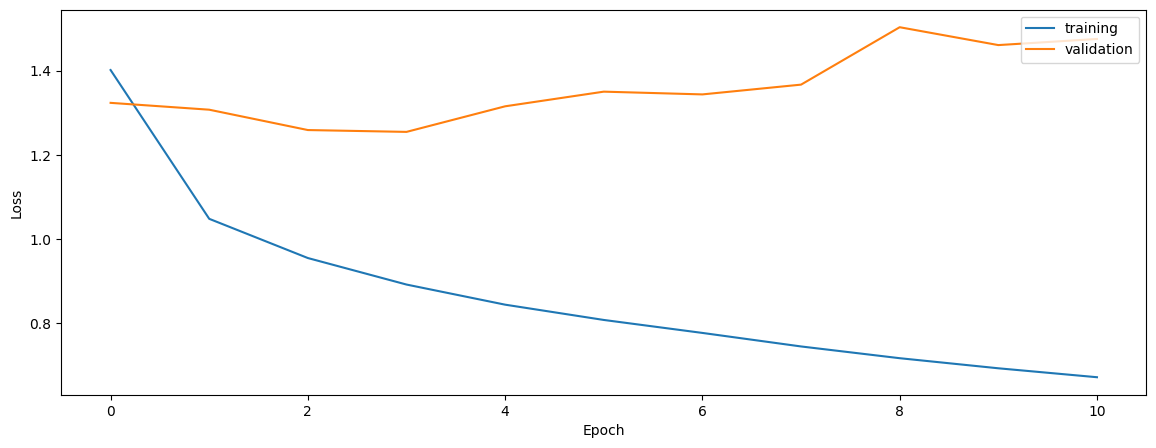

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6726453723883051
0.5257055529999596
0.444393392038916


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.6176227132673711
0.49526736753868184
0.5531756513386962


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.613809118094188
0.5015057406361754
0.5468908243872798


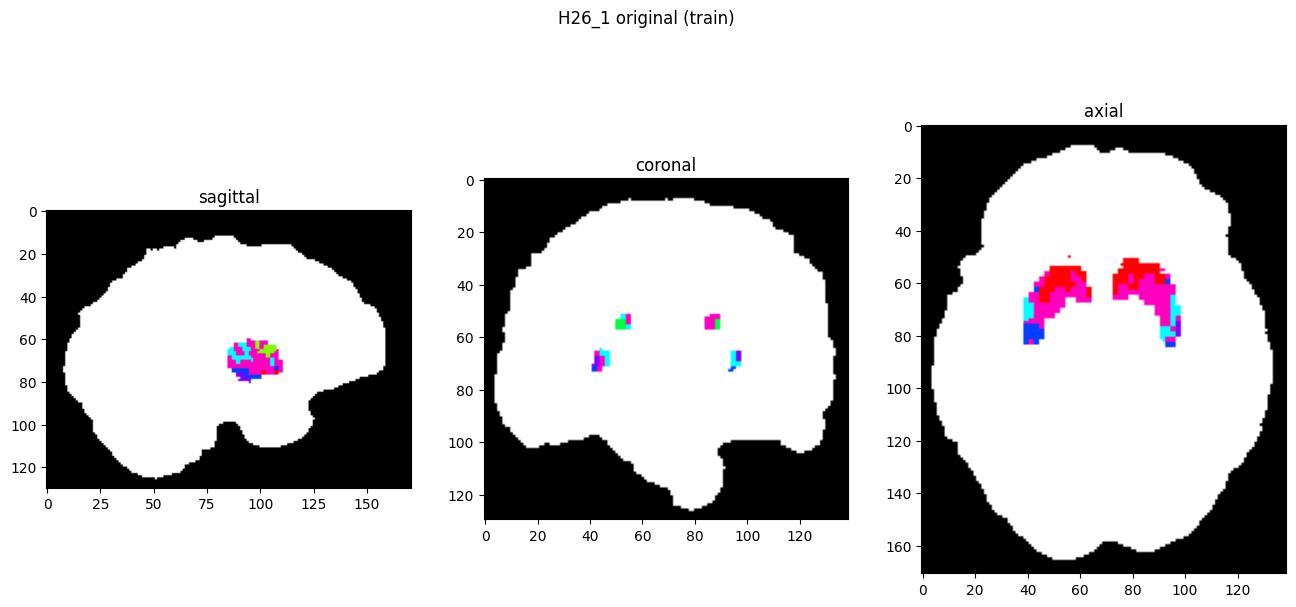

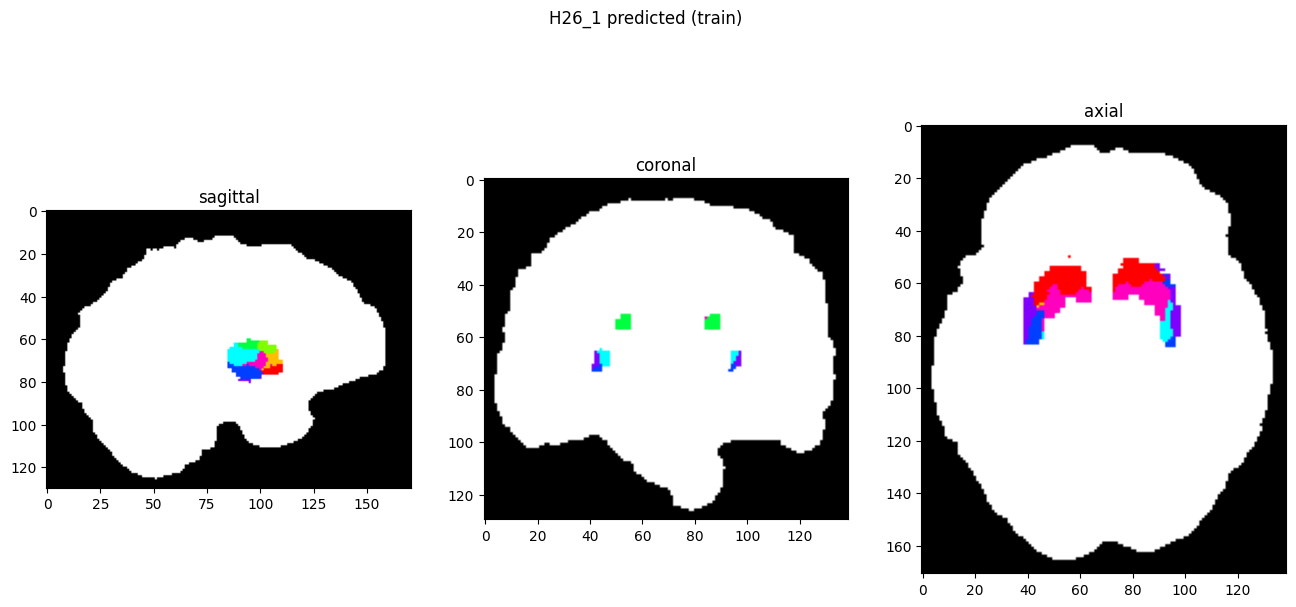

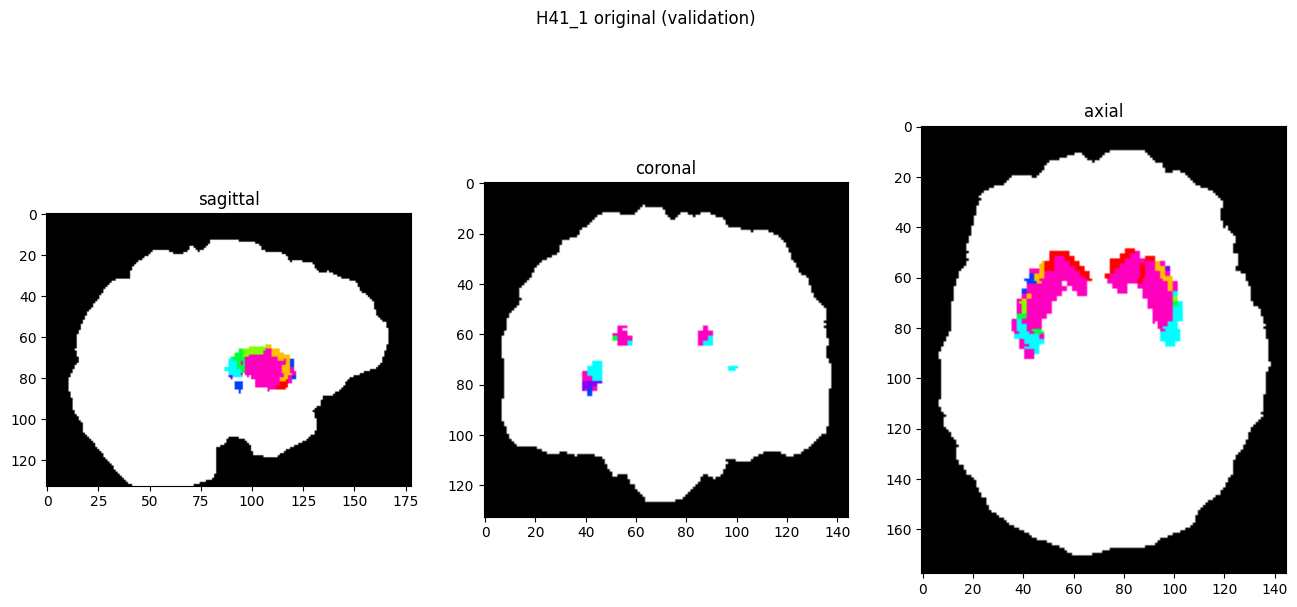

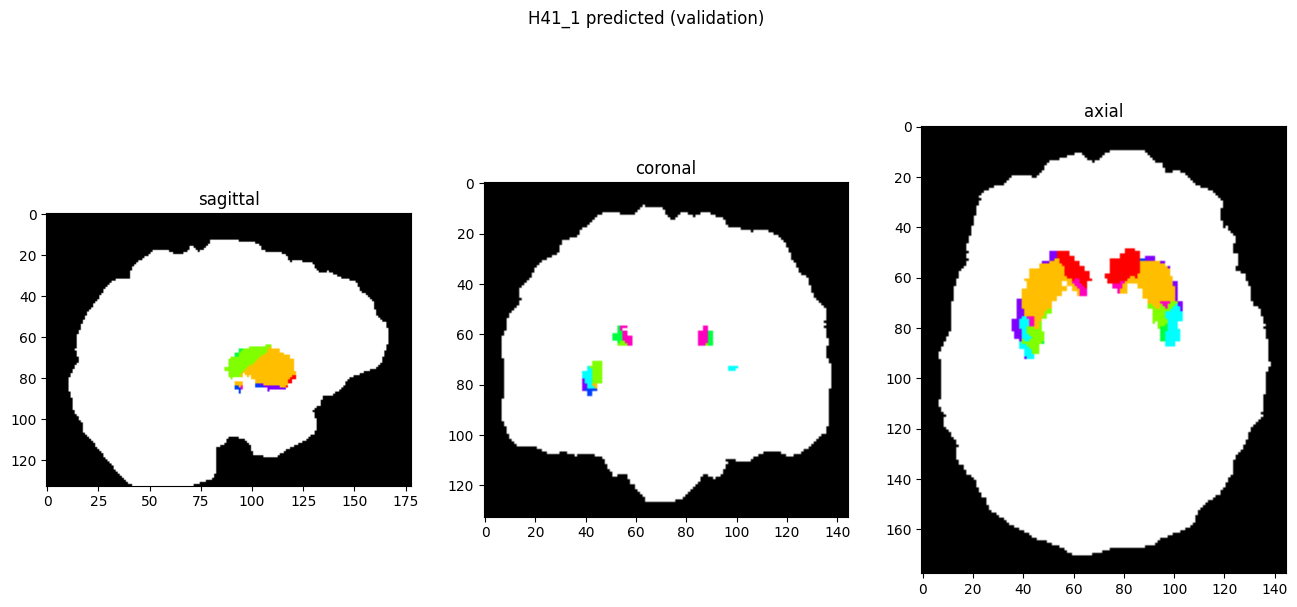

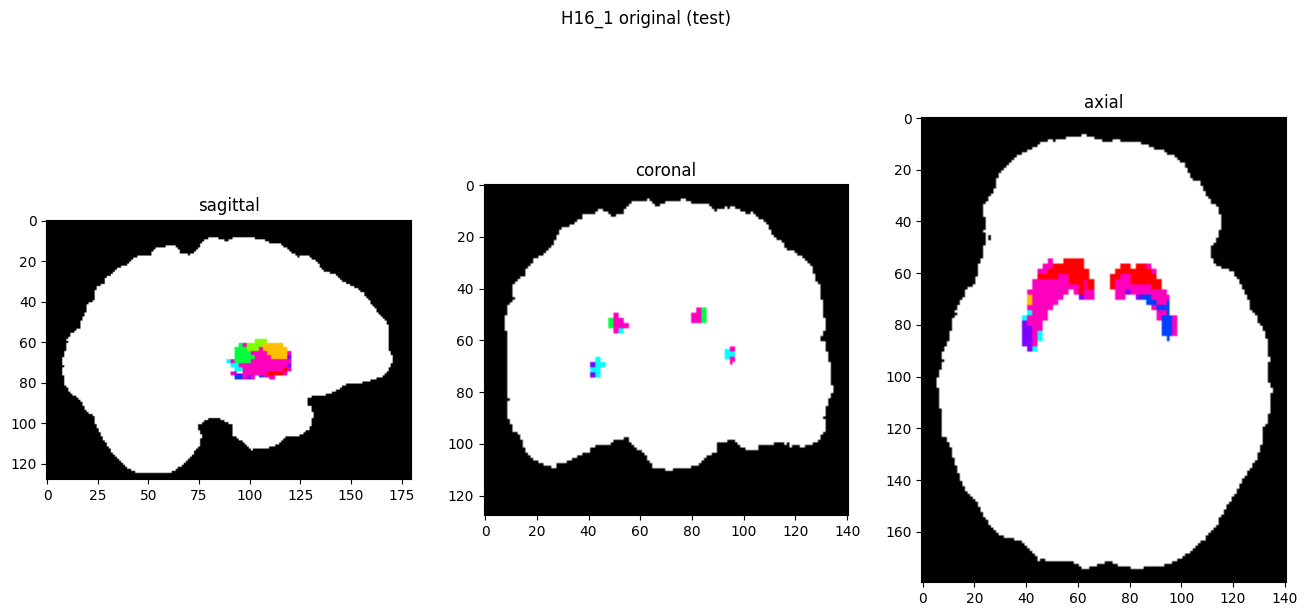

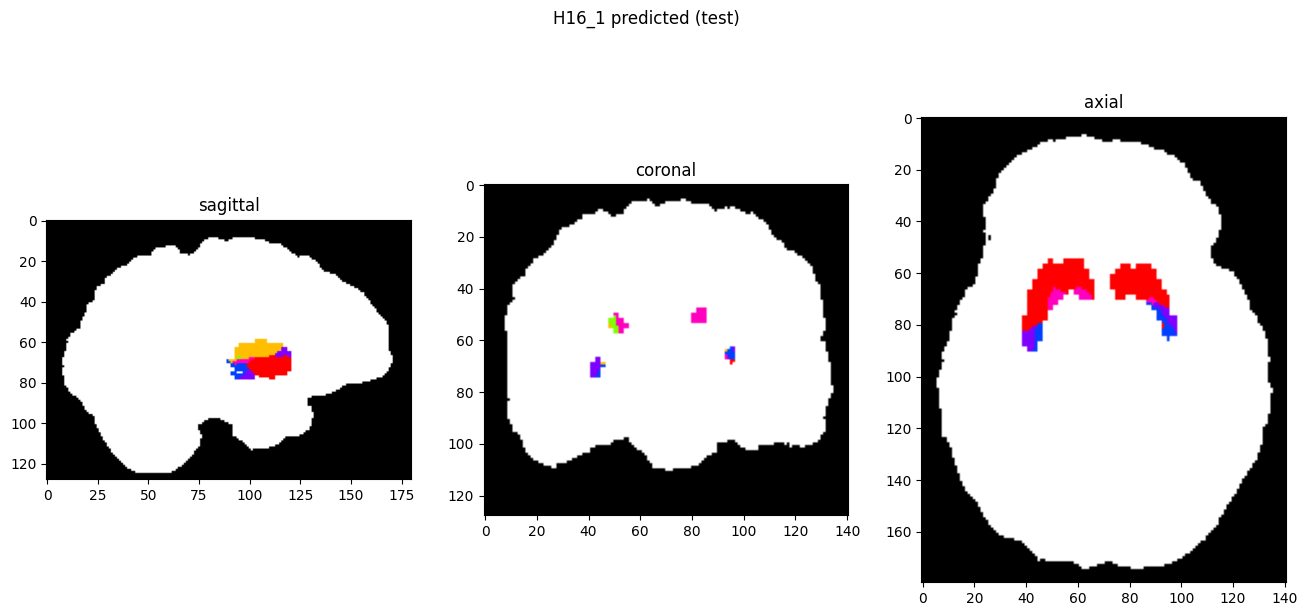

In [10]:
showResults(model, gen, threshold=0)